# Steel Plate Detection Prediction

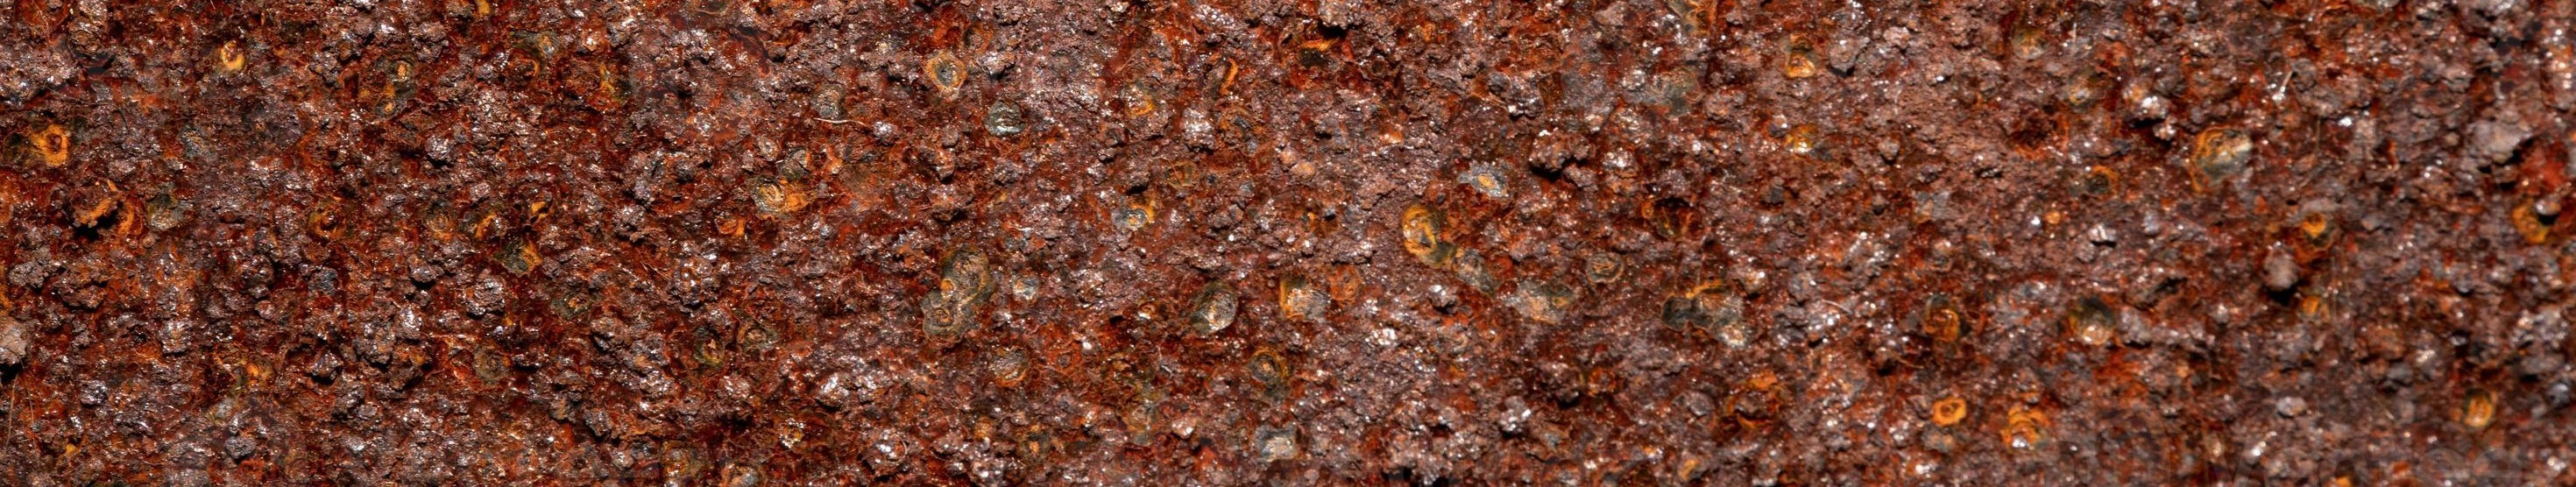

1. __Dataset Description__
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Steel Plates Faults dataset from UCI. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

2. __Files__
`train.csv` - the training dataset; there are 7 binary targets: `Pastry`, `Z_Scratch`, `K_Scatch`, `Stains`, `Dirtiness`, `Bumps`, `Other_Faults`
`test.csv` - the test dataset; your objective is to predict the probability of each of the 7 binary targets
`sample_submission.csv` - a sample submission file in the correct format

3. __Evaluation__
Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.
To calculate the final score, AUC is calculated for each of the 7 defect categories and then averaged. In other words, the score is the average of the individual AUC of each predicted column.

4. __Submission File__
For each id in the test set, you must predict the probability for each of 7 defect categories: Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults. The file should contain a header and have the following format:

    ```python
    id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
    19219,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    19220,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    19221,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    etc.
    ```

5. __Citation__
    * <a href="https://kaggle.com/competitions/playground-series-s4e3">Walter Reade, Ashley Chow, Steel Plate Defect Prediction, Kaggle, 2024</a>

## Import Dependencies

In [204]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from math import ceil
from scipy.stats import randint, uniform
import json
import os

## Helper Functions

In [205]:
# Save model parameters
def save_params(params, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'w') as file:
        json.dump(params, file)
    print(f"Best parameters saved to: '{filename}'.")
 
 
    
# Load model parameters
def load_params(filename):
    try:
        with open(filename, 'r') as file:
            params = json.load(file)
    except json.JSONDecodeError:
        raise ValueError(f"Error: '{filename}' is not a valid JSON file or is empty.")
    else:
        print(f"Parameters loaded from: '{filename}'.")
        
    return params



# Remove all-zero rows
def remove_all_zero_columns(df:pd.DataFrame):
    all_zero_rows = df.sum(axis=1)==0
    print(f'Removing {len(all_zero_rows)} rows ...')
    return df[~all_zero_rows].reset_index(drop=True)



def compute_lower_upper_bounds(df:pd.DataFrame, col:str, method:str='IQR', **kwargs) -> tuple:
    """

    Args:
        df (pd.DataFrame): dataframe to compute the lower and upper bounds
        col (str): column in 'df' to compute the bounds
        method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'IQR'.
        **kwargs:
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.01, 0.99).

    Returns:
        tuple: (lower_bound, upper_bound) - lower and upper bounds for the column 'col' in 'df'
    """
    
    try:
        if method == 'IQR':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
        elif method == 'ZScore':
            mean = df[col].mean()
            std = df[col].std()
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
        elif method == 'Percentile':
            limits = kwargs.get('limits', (0.01, 0.99))
            lower_bound = df[col].quantile(limits[0])
            upper_bound = df[col].quantile(limits[1])
    except Exception as e:
        print(f'Error: {e}')
        return None, None
    return lower_bound, upper_bound
    
    
    
def mask_outliers(df: pd.DataFrame, col:str, method:str='Percentile', **kwargs) -> pd.Series:
    """_summary_

    Args:
        df (pd.DataFrame): dataframe to mask the outliers
        col (str): column in 'df' to check for outliers
        method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'Percentile'.
        **kwargs:
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.01, 0.99).

    Returns:
        pd.Series: provide outlier mask for the column 'col' in 'df'
    """
    outlier_mask = pd.Series(False, index=df.index)
    lower_bound, upper_bound = compute_lower_upper_bounds(df, col, method, limits=kwargs.get('limits', (0.01, 0.99)))
    outlier_mask = outlier_mask | ((df[col] < lower_bound) | (df[col] > upper_bound))
    return outlier_mask



# Remove outliers rows
def remove_outliers(df:pd.DataFrame, y:pd.DataFrame=None, cols=[], **kwargs) -> tuple:
    """_summary_

    Args:
        df (pd.DataFrame): dataframe to remove outliers from
        y (pd.DataFrame, optional): target dataframe. Defaults to None.
        cols (list, optional): columns in 'df' to check for outliers. Defaults to [].
        **kwargs:
            method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'Percentile'.
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.0005, 0.9995).

    Returns:
        tuple: (df_cleaned, y_cleaned) - cleaned dataframes
    """
    
    method = kwargs.get('method', 'Percentile')
    limits = kwargs.get('limits', (0.0005, 0.9995))
    cols = df.columns if cols==[] else cols
    
    outlier_mask = np.zeros(df.shape[0], dtype=bool)
    for col in cols:
        mask = mask_outliers(X, col, method=method, limits=(0.0005, 0.9995))
        outlier_mask |= mask # Combine masks for all columns
    return df[~outlier_mask], (y[~outlier_mask] if y is not None else None)



def count_outliers(df: pd.DataFrame, cols=[], method='Percentile', **kwargs) -> pd.Series:
    """

    Args:
        df (pd.DataFrame): dataframe to count the outliers
        cols (list, optional): columns in 'df' to count its outliers. Defaults to [].
        method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'Percentile'.
        **kwargs:
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.01, 0.99).

    Returns:
        pd.Series: number of outliers for each column in 'cols'
    """
    if cols==[]: cols = df.columns
    outlier_counts = pd.Series(index=cols, dtype='float64')
    for col in cols:
        lower_bound, upper_bound = compute_lower_upper_bounds(df, col, method=method, limits=kwargs.get('limits', (0.01, 0.99)))
        outlier_counts[col] = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    return outlier_counts

#### Outliers

Outliers can affect model accuracy, especially for models that are sensitive to the range of the data, such as regression models. Here are some common methods to detect outliers in one-dimensional (univariate) data:

1. __Z-Score:__
Outliers are typically defined as points that have a Z-score greater than 3 or less than -3

2. __Interquartile Range (IQR):__
The IQR method defines outliers as points that fall below the first quartile (Q1) or above the third quartile (Q3) by a certain multiple of the IQR (commonly 1.5 times).

3. __Percentile-Based Method:__
This method flags values that fall beyond a specified percentile range, such as the 1st and 99th percentiles.
<br><br>


| Method               | Data Type              | Distribution Suitability       | Best For                   | Not Recommended When                  |
|----------------------|------------------------|--------------------------------|----------------------------|----------------------------------------|
| **Z-Score**          | Continuous             | Normal (Gaussian)              | Large datasets, quick detection | Skewed distributions, extreme outliers|
| **IQR**              | Continuous             | Any (especially non-normal)    | Skewed data, small datasets  | Uniform data, when mild outliers matter|
| **Percentile-Based** | Continuous             | Skewed or non-normal           | Large datasets, extreme outliers | Normally distributed data|



## Import Datasets

In [206]:
# Read csv files
data = pd.read_csv('./data/train.csv', header=0, index_col=0)
test = pd.read_csv('./data/test.csv', header=0, index_col=0)

# Create target and train dataframes
target_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target = data[target_columns]
train = data.drop(target_columns, axis=1)

print(f'tarin: {train.shape}')
print(f'target: {target.shape}')
print(f'test: {test.shape}')

tarin: (19219, 27)
target: (19219, 7)
test: (12814, 27)


### 1. Target (Labels)

In [207]:
# Intances with at least one defect
positive_class = []
negative_class = []
for col in target_columns:
    percent = target[col].value_counts(normalize=True).round(3)*100
    negative_class.append(percent[0])
    positive_class.append(percent[1])
target_min1 = pd.DataFrame({'Class': target_columns, 'Negative': negative_class, 'Positive': positive_class}).sort_values(by='Positive', ascending=False)


# Intances with more than one defect
target_1plus = target[target.sum(axis=1)>1].value_counts().sum()


# Intances with no defect
target_0 = target[target.sum(axis=1)==0].value_counts().sum()


print(f'Instances with more than one defect: {target_1plus} ({target_1plus/len(target)*100:.2f}%)')
print(f'Instances with no defect: {target_0} ({target_0/len(target)*100:.2f}%)')

Instances with more than one defect: 21 (0.11%)
Instances with no defect: 818 (4.26%)


The rows with all-zero labels (i.e., no defect) represent a significant imbalance in the data, removing them could potentially improve performance, especially when models are struggling to learn patterns for the minority classes because the removed instances may contribute less valuable information to the model’s decision-making process. However, this could also introduce a bias if those all-zero instances have important relationships with features that the model should learn. Here, I do not remove these insances.

Additionally, there are instances that have more than one defect. This make the probelm a multi-label classification, because the labels are not mutually exclusive. Here, I will also keep these instances.

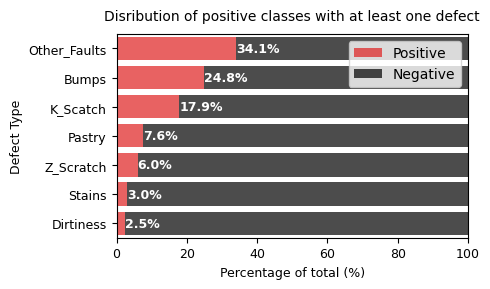

In [285]:
plt.figure(figsize=(5, 3))
ax = sns.barplot(x='Positive', y='Class', data=target_min1, width=.8, color='red', alpha=0.7, orient='h', label='Positive')
ax.bar_label(ax.containers[0], fmt="%.1f%%", fontsize=9, color='white', weight='bold')
sns.barplot(x='Negative', y='Class', data=target_min1, width=.8, color='black', alpha=0.7, orient='h', left=target_min1['Positive'], label='Negative')
ax.set_xlim(0, 100)
plt.xlabel('Percentage of total (%)', fontsize=9)
plt.ylabel('Defect Type', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
# plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncols=2, fontsize=9)
plt.title('Disribution of positive classes with at least one defect', fontsize=10, pad=10)
plt.tight_layout()
plt.savefig('./images/target_positive_classes.png', dpi=300)
plt.show()

### 1.2. Target Correlation

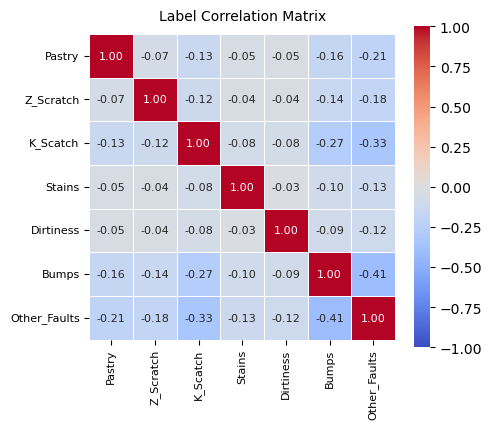

In [346]:
from tkinter import font


target_corr = target.corr(method='spearman') 

plt.figure(figsize=(5, 5))
ax = sns.heatmap(target_corr, annot=True, fmt=".2f", annot_kws={'fontsize': 8}, cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={'shrink': 0.75}, vmin=-1, vmax=1)
plt.title("Label Correlation Matrix", fontsize=10, pad=10)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.savefig('./images/target_correlation_matrix.png', dpi=300)
plt.show()


#### Conditional Probability Analysis

It is the conditional probability of one label being positive given that another label is positive. This can highlight direct dependencies. If P(Label A∣Label B) is high, Label A is likely to occur whenever Label B does, suggesting dependency.

The line `np.mean(target[label_a][target[label_b] == 1])` computes the conditional probability P(A=1∣B=1), where:

* A is the event that `label_a` is 1.
* B is the event that `label_b` is 1.

__Conditional Probability__

The conditional probability of A given B is defined as:

$$P(A=1|B=1)=\frac{\text{Number of occurences where A=1 and B=1}}{\text{Number of occurences where B=1}}$$

This represents the proportion of cases where A is 1 among the cases where B is 1.

* `target[label_b] == 1` creates a boolean mask, selecting only rows where `label_b` is 1.
* `target[label_a][...]` uses this mask to select the values of `label_a` only for the rows where `label_b` is 1.
* `np.mean(...)` calculates the average of this filtered subset.
* Since `label_a` is a binary variable (0 or 1), taking the mean of this subset is equivalent to calculating the proportion of rows where `label_a` is 1 among the rows where `label_b` is 1.


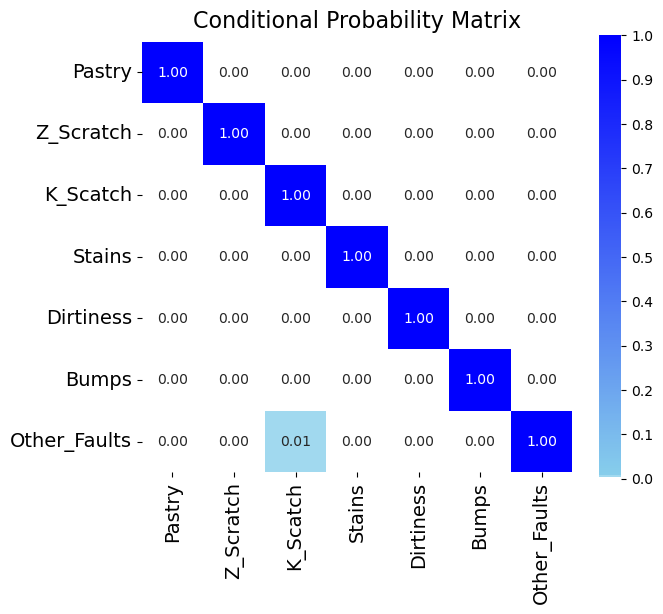

In [400]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, "white"),
                # (0.0005, "lightblue"),
                (0.005, "skyblue"),
                # (0.05, "royalblue"),
                (1, "blue")] 

cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

conditional_prob_matrix = pd.DataFrame(index=target.columns, columns=target.columns)

for label_a in target.columns:
    for label_b in target.columns:
        conditional_prob = np.mean(target[label_a][target[label_b] == 1])
        conditional_prob_matrix.loc[label_a, label_b] = conditional_prob

plt.figure(figsize=(7, 7))
ax = sns.heatmap(conditional_prob_matrix.astype(float), annot=True, fmt='.2f', 
                 annot_kws={'fontsize': 10}, square=True, cmap=cmap,
                 cbar_kws={'shrink': 0.75, 'ticks': np.arange(0, 1.1, 0.1)})
plt.title("Conditional Probability Matrix", fontsize=16, pad=10)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.savefig('./images/target_conditional_probability_matrix.png', dpi=300)
plt.show()


### 2. Features

#### 2.1. Distribution

* `Train` and `Test` datasets have coparable distributions
* Not all features are notmally distributed
* There are outliers in dataset

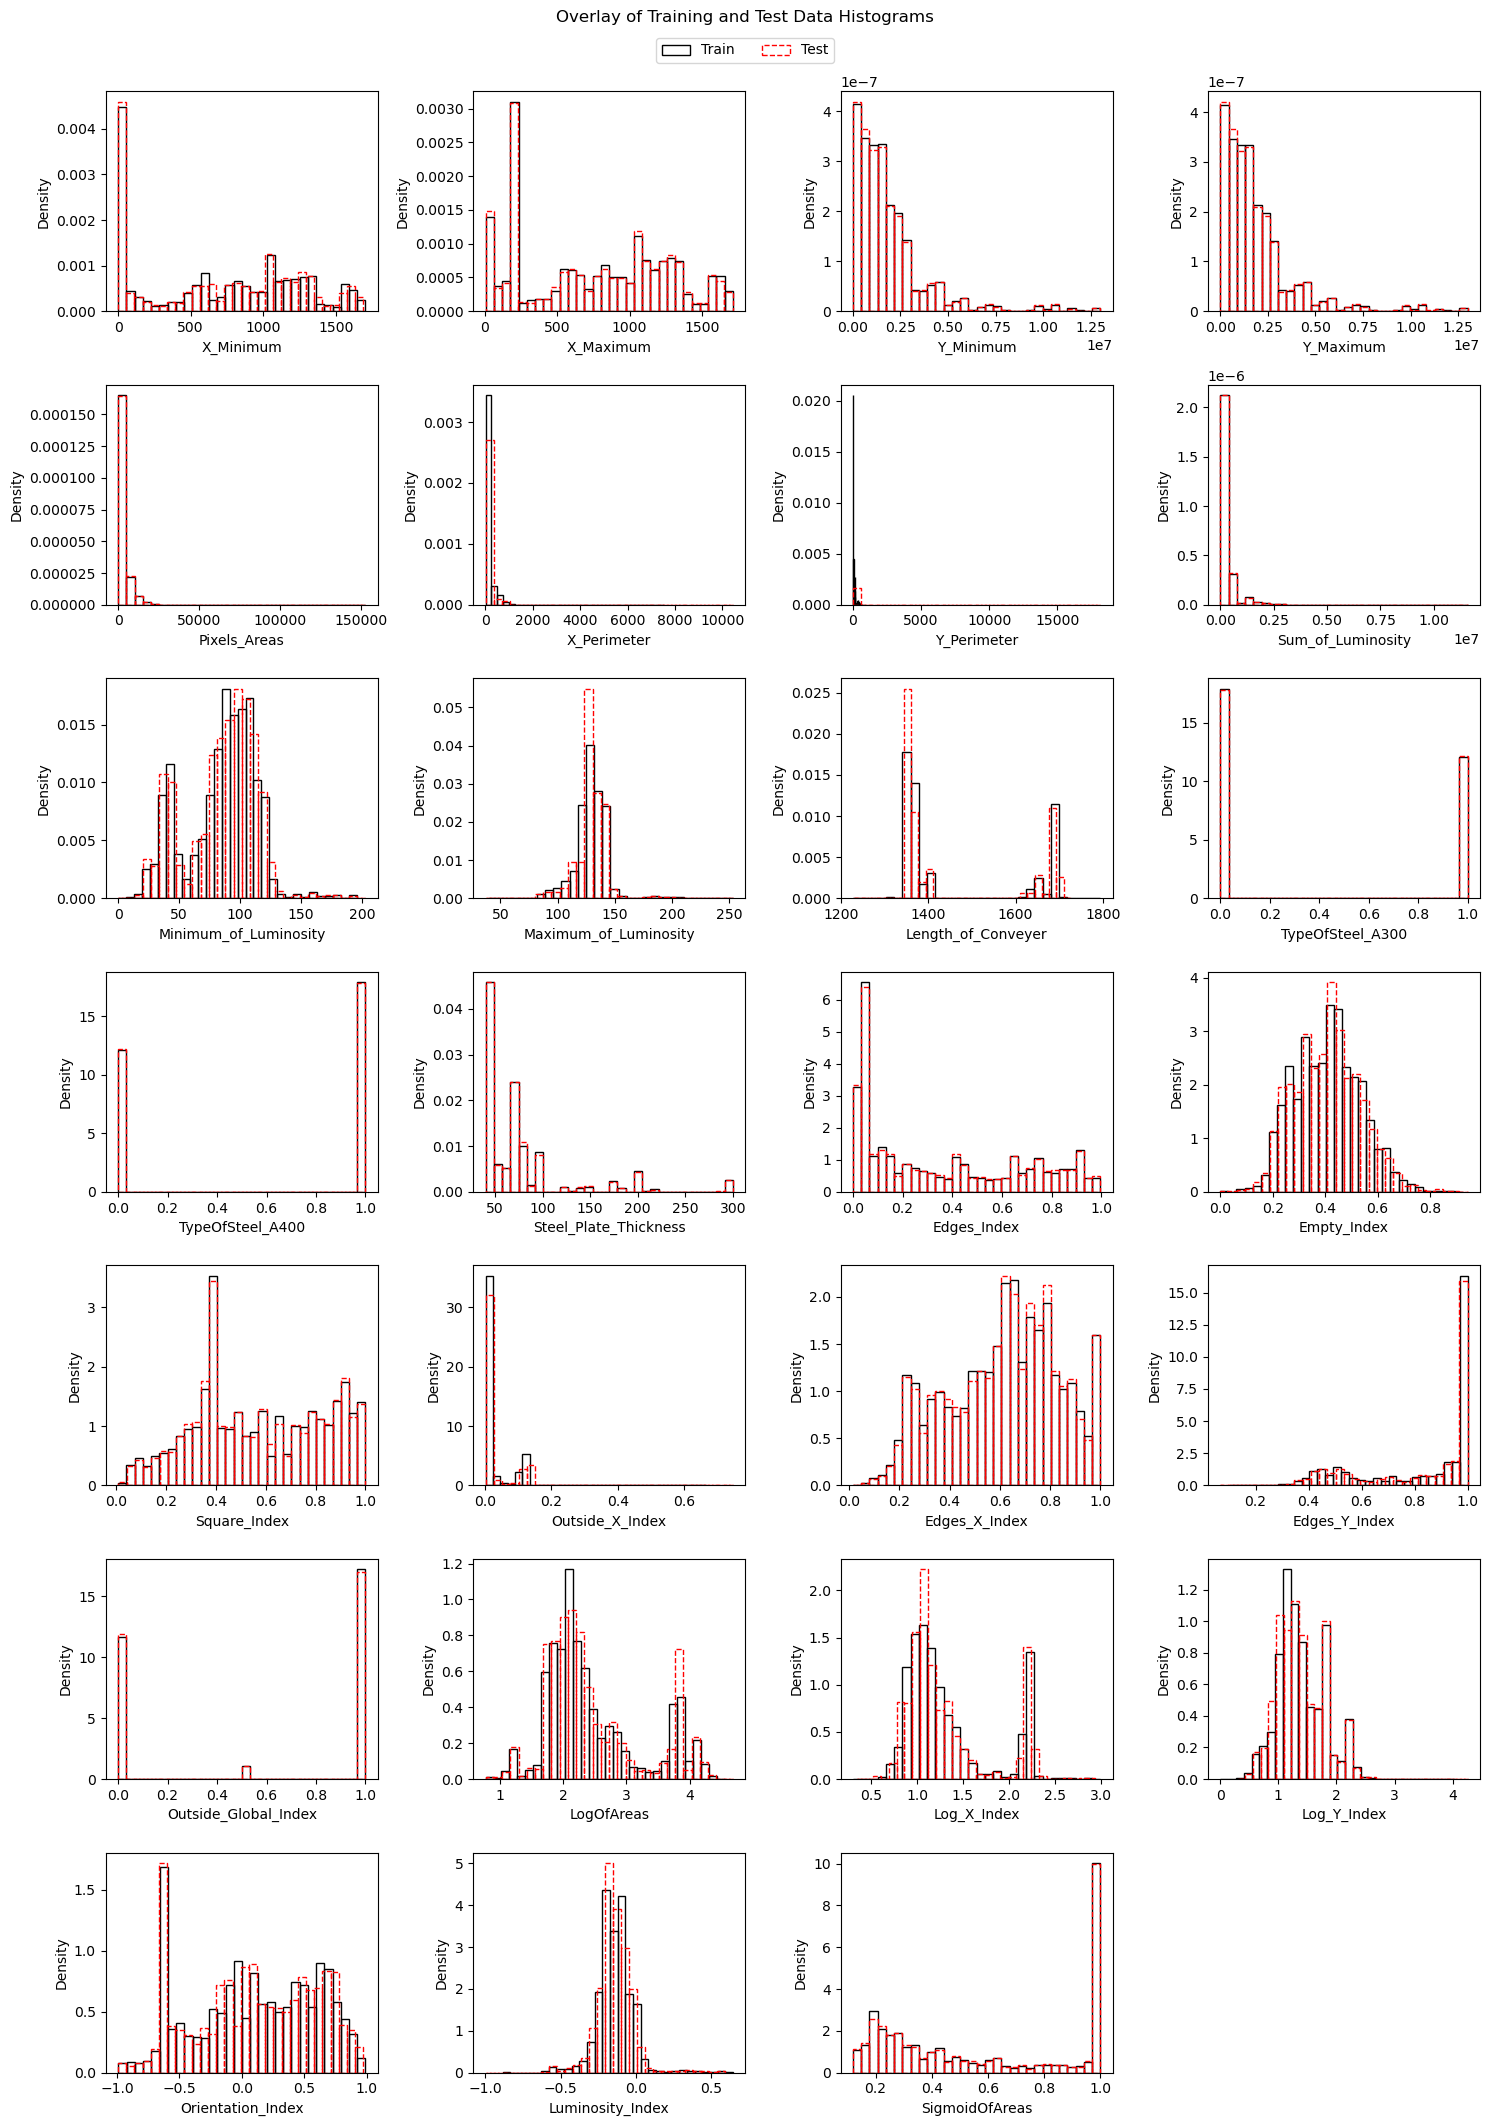

In [209]:
def overlay_hist(train_df, test_df, ncols):
    nrows = ceil(train_df.shape[1]/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    axes = axes.flatten()
    features = train_df.columns
    for i in range(len(axes)):
        try:
            feature = features[i]
            sns.histplot(train_df[feature], color='black', linewidth=1.0, fill=False, label='Train', kde=False, stat='density', bins=30, alpha=1.0, ax=axes[i])
            sns.histplot(test_df[feature], color='red', linewidth=1.0, linestyle='--', fill=False, label='Test', kde=False, stat='density', bins=30, alpha=1.0, ax=axes[i])
            axes[i].set_xlabel(feature)
            axes[i].grid(False)
        except IndexError:
            fig.delaxes(axes[i])
    fig.suptitle('Overlay of Training and Test Data Histograms', y=1.01)
    handles, labels = axes[0].get_legend_handles_labels()    
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2, fontsize='medium')
    plt.tight_layout()
    plt.show()
    
    
overlay_hist(train, test, 4)

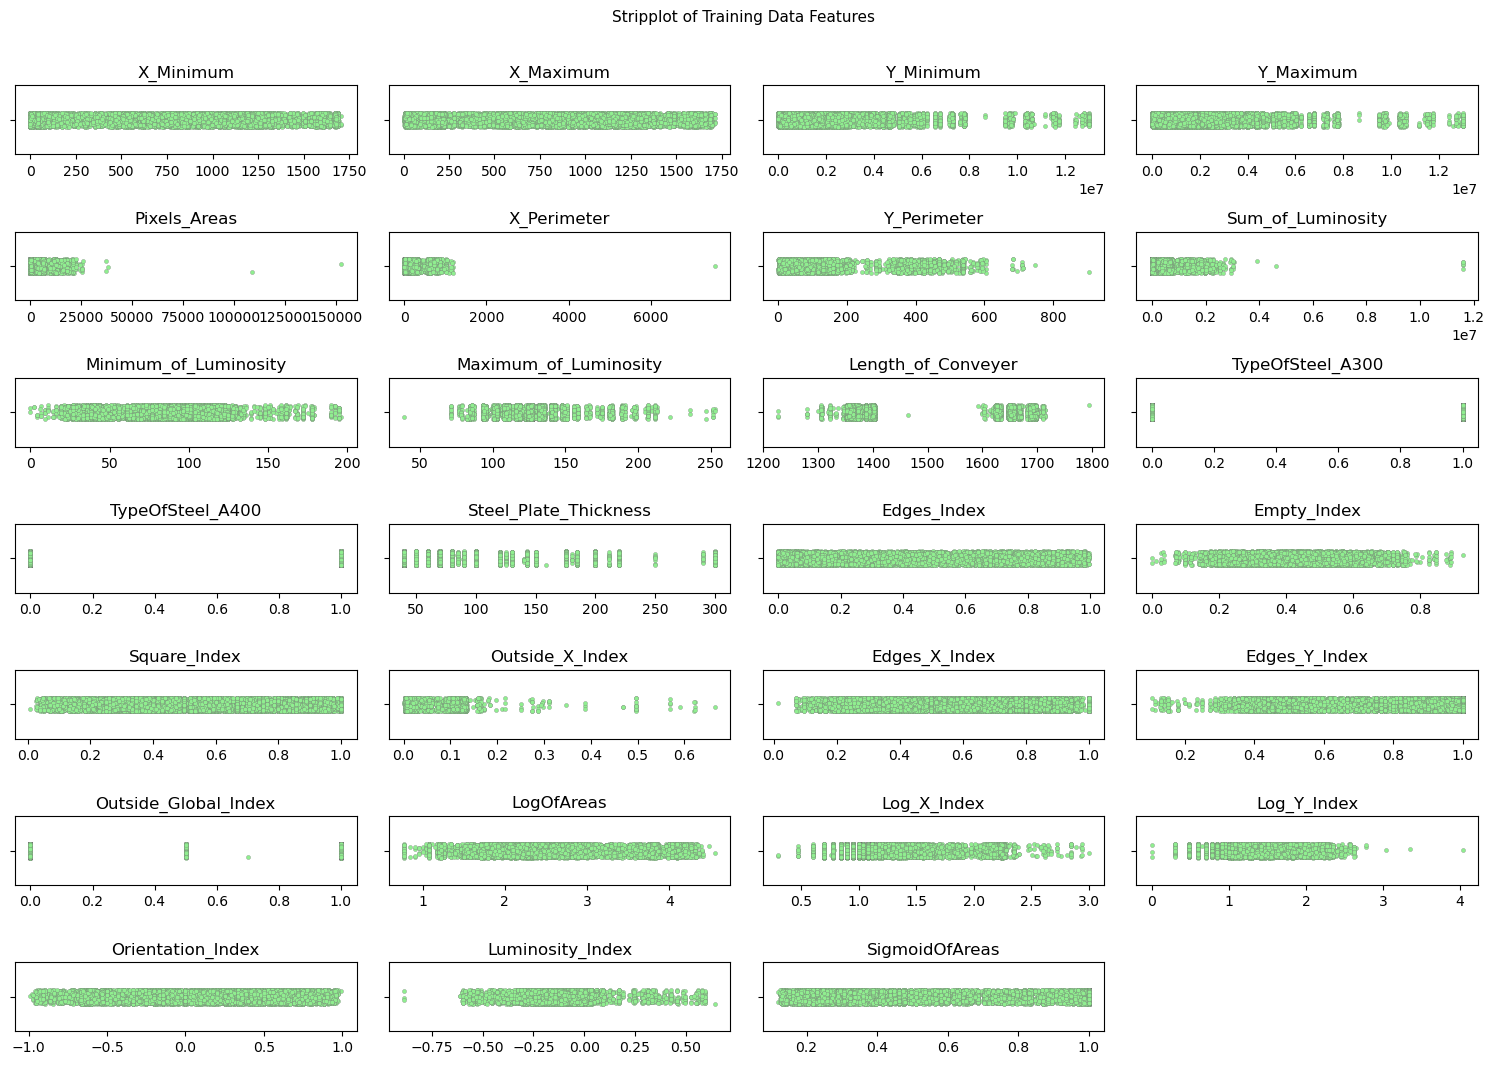

In [210]:
ncols = 4
nrows = ceil(train.shape[1]/ncols)

fig, ax = plt.subplots(nrows, ncols, figsize=(15, 1.5 * nrows))
ax = ax.ravel()

for i, col in enumerate(train.columns):
    sns.stripplot(x=train[col], color='lightgreen', size=3, dodge=True, jitter=True, linewidth=0.2, ax=ax[i])

    ax[i].set_title(col)
    ax[i].set_xlabel('')
    
for j in range(i+1, len(ax)):
    fig.delaxes(ax[j])
    
fig.suptitle('Stripplot of Training Data Features', y=1.01, fontsize=11)    
plt.tight_layout()
plt.show()

### 2.2. Correlation

Three correlation methods, **Pearson**, **Kendall**, and **Spearman**, are common ways to measure relationships between variables, each with its own approach to quantifying correlation. 

| Method   | Measures            | Data Type        | Assumptions      | Strengths                  |
|----------|---------------------|------------------|------------------|----------------------------|
| Pearson  | Linear relationship | Continuous | Normally distributed | Best for linear relationships |
| Kendall | Ordinal association | Ordinal, non-parametric | None | Robust to outliers, good for small samples |
| Spearman | Monotonic relationship | Ordinal or non-normally distributed | None | Captures non-linear monotonic relationships |


__Spearman__ method assesses how well the relationship between two features of the dataset can be represented by a monotonic function.

It ranks each variable individually, then calculates Pearson’s correlation on the ranked data rather than the original data.

$$r_s = 1 - \frac{6 \sum{d_i^2}}{n(n^2-1)}$$

where $d_i$ is the difference in ranks for each observation, and $n$ is the number of observations. The Spearman's values range from -1 to 1. $r_s=1$ means perfect positive monotonic relationship while whereas $r_s=-1$ means perfect negative monotonic relationship. $r_s=0$ indicates no monotonic relationship.



In [211]:
cat_features = ['TypeOfSteel_A300', 'TypeOfSteel_A400']
num_features = [feature for feature in train.columns if feature not in cat_features]

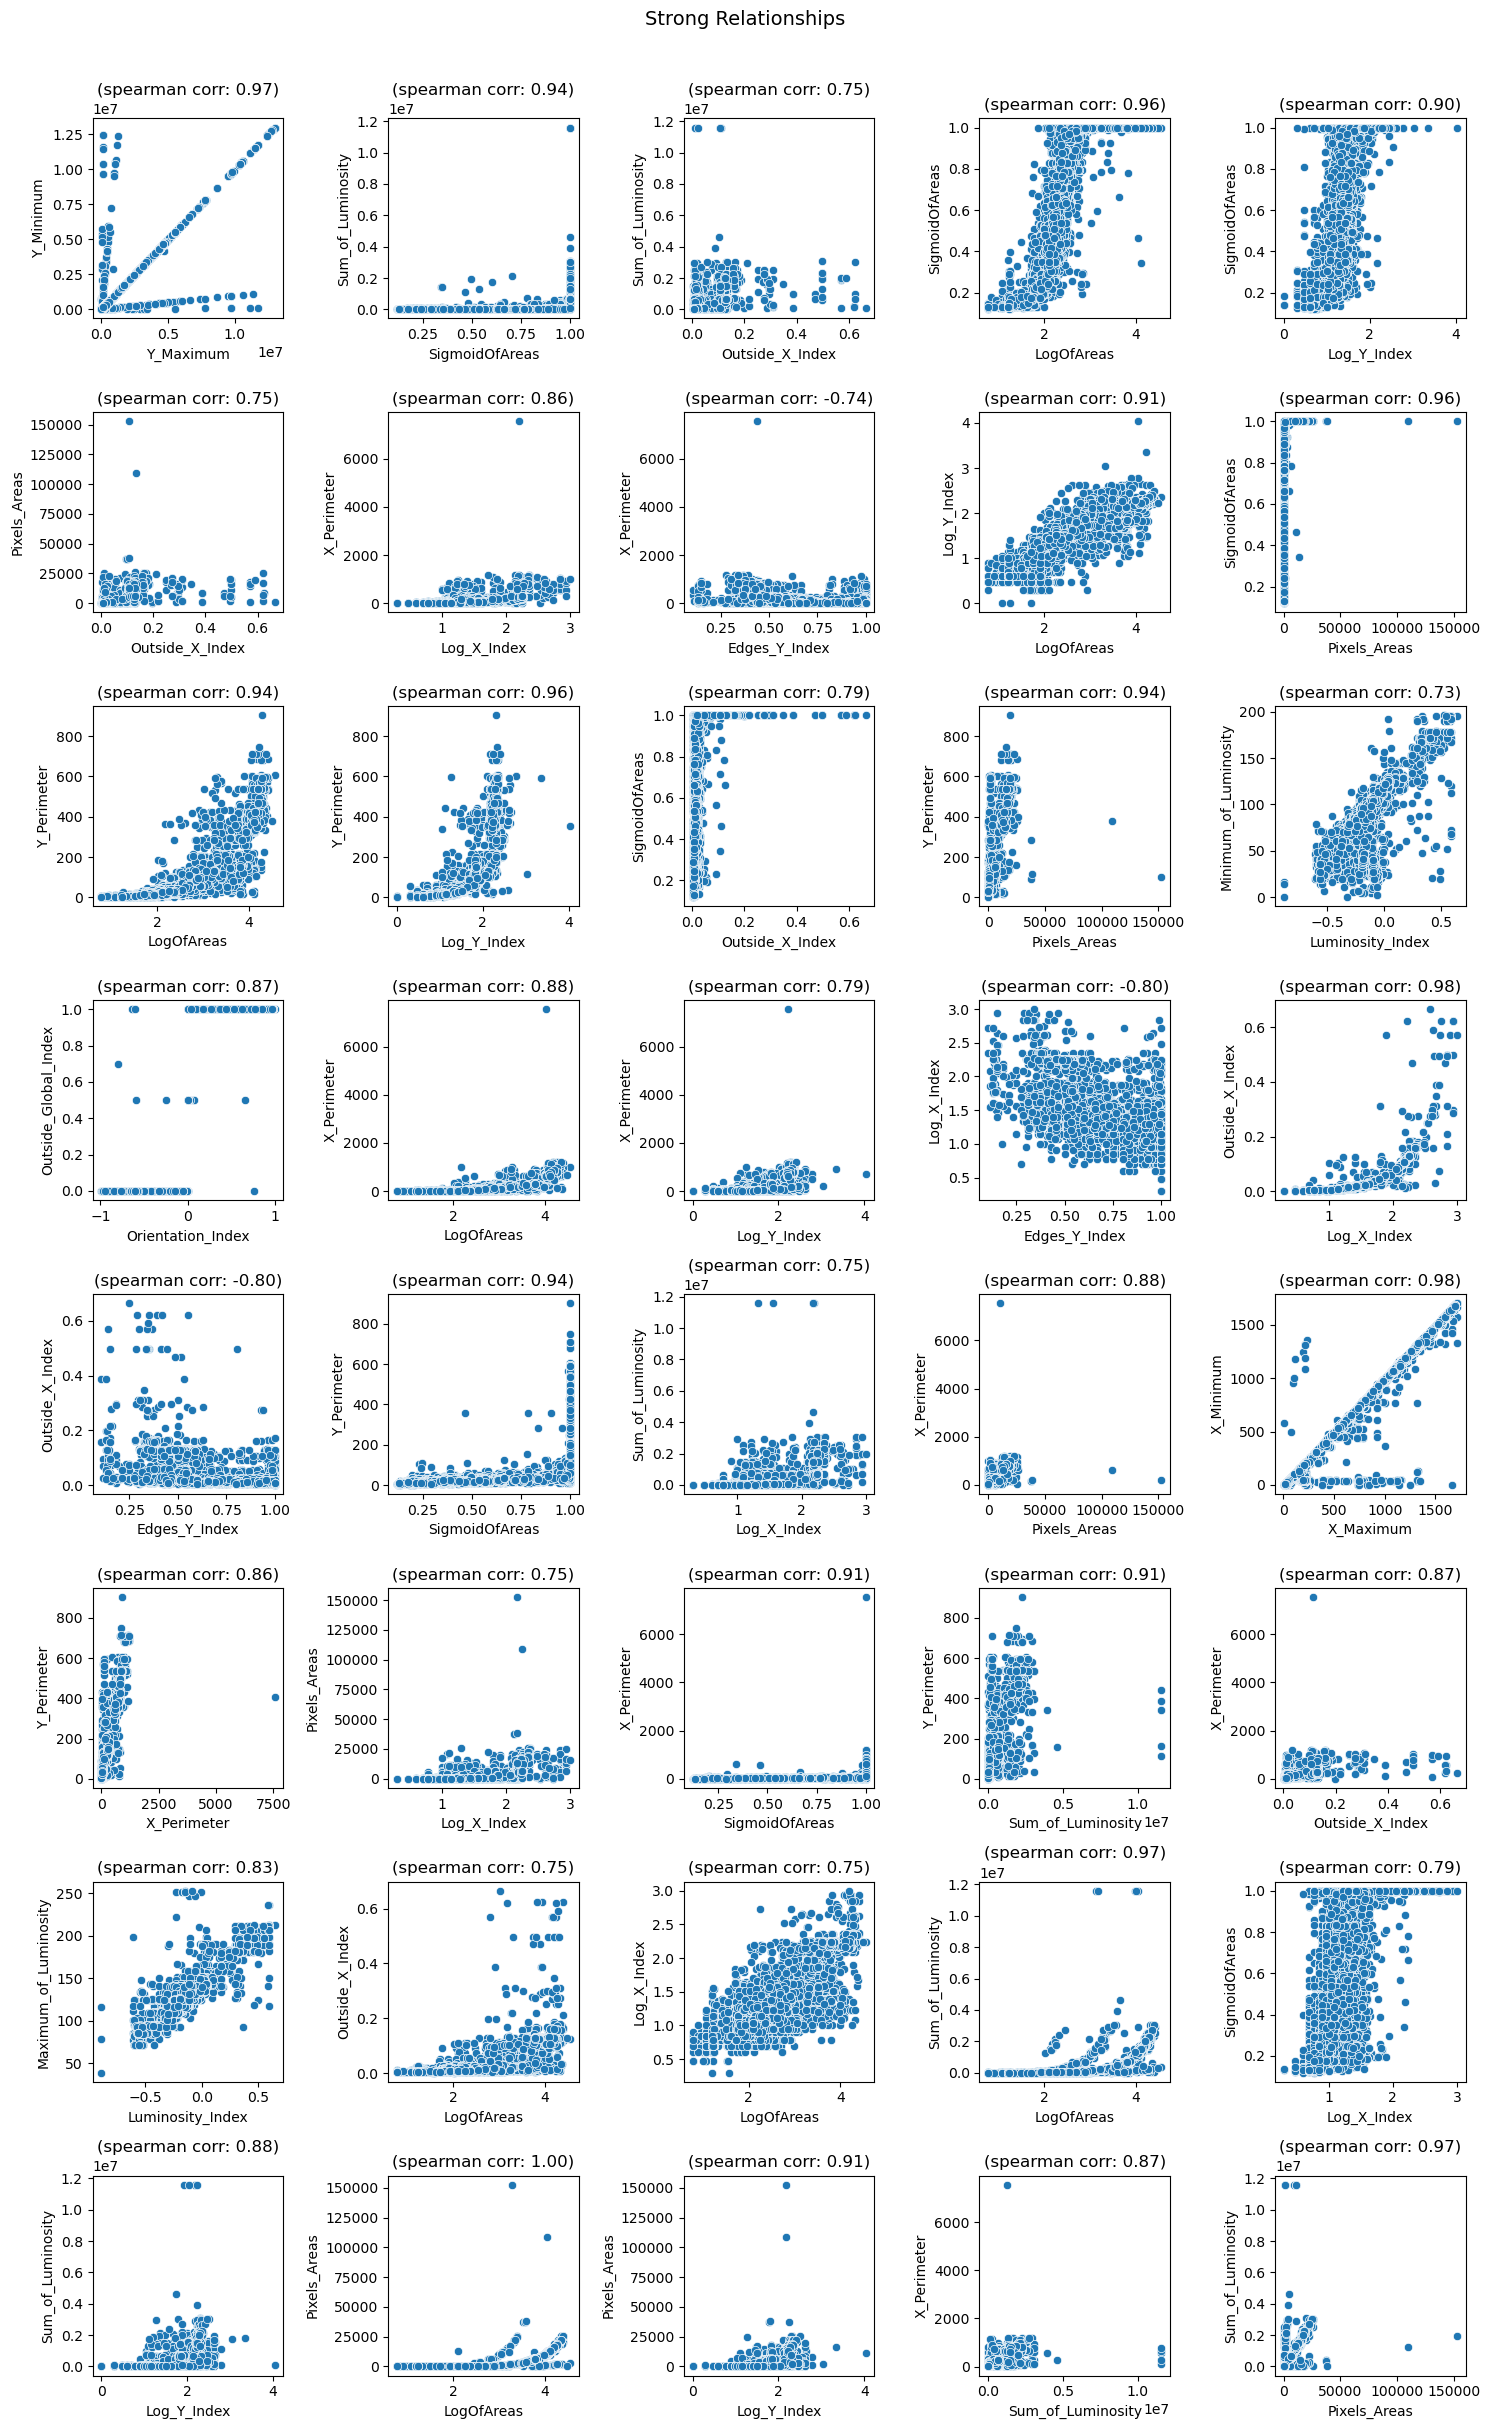

In [212]:
# Identify pairs with strong monotonic relationships

corr_thr = 0.70
corr_method = 'spearman'
corr = train[num_features].corr(corr_method)

strong_pairs = [
    (col1, col2) for col1 in corr.columns for col2 in corr.columns
    if col1 != col2 and abs(corr.loc[col1, col2]) > corr_thr
]

strong_pairs = list(set(tuple(sorted(pair)) for pair in strong_pairs))




ncols = 5
nrows = ceil(len(strong_pairs)/ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))
axes = axes.flatten()  

for i, (col1, col2) in enumerate(strong_pairs):
    ax = axes[i] 
    sns.scatterplot(data=train, x=col1, y=col2, ax=ax)
    ax.set_title(f"({corr_method} corr: {corr.loc[col1, col2]:.2f})")
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Strong Relationships', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()


#### 2.2.1. Heatmap

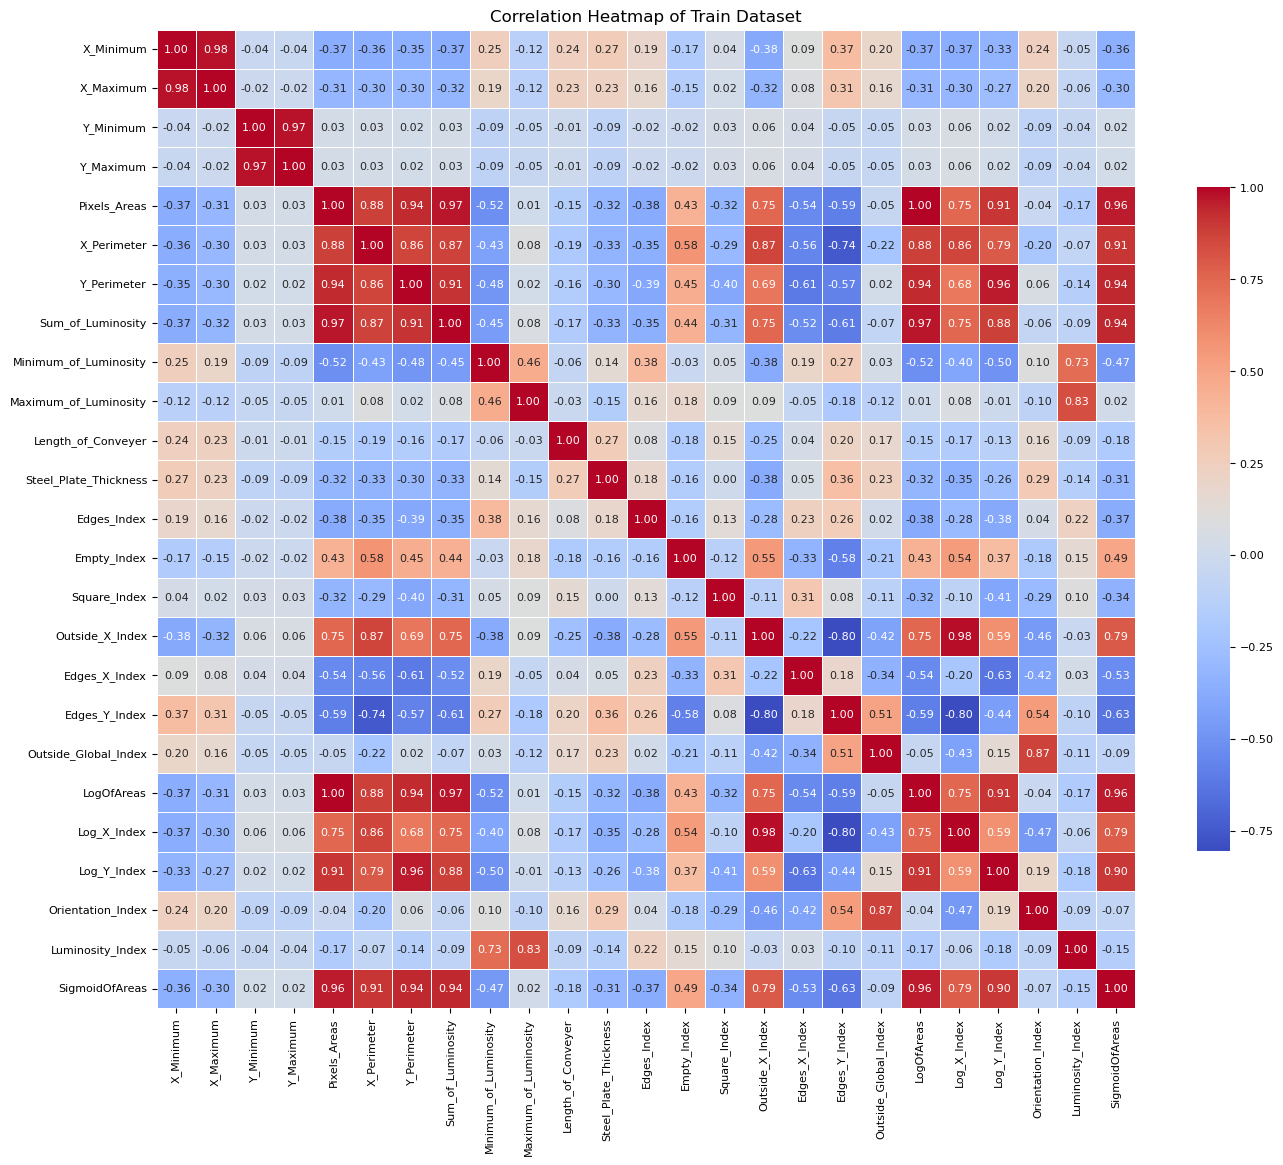

In [213]:
plt.figure(figsize=(14, 14))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'fontsize': 8}, cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title('Correlation Heatmap of Train Dataset')
plt.tight_layout()
plt.show()

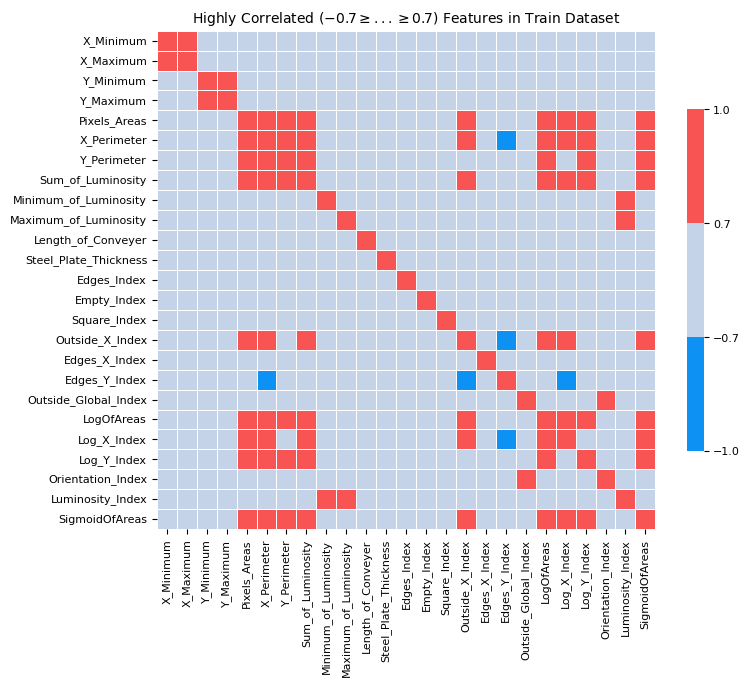

In [214]:
import matplotlib.colors as mcolors


plt.figure(figsize=(8, 8))
cmap = mcolors.ListedColormap(['#0D92F4', '#C5D3E8', '#F95454'])
bounds = [-1, -corr_thr, corr_thr, 1] # Define the boundaries and normalization
norm = mcolors.BoundaryNorm(bounds, cmap.N)
ax = sns.heatmap(corr, annot=False, cmap=cmap, norm=norm, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
# ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title(fr'Highly Correlated (${-corr_thr}\geq ... \geq {corr_thr}$) Features in Train Dataset', fontsize=10)
plt.tight_layout()

In [215]:
strong_corr_pairs = []
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
        if abs(corr.iloc[i, j]) >= corr_thr:
            strong_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j].round(3)))

high_corr_df = pd.DataFrame(strong_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_df

,Feature 1,Feature 2,Correlation
0,X_Minimum,X_Maximum,0.978
1,Y_Minimum,Y_Maximum,0.974
2,Pixels_Areas,X_Perimeter,0.878
3,Pixels_Areas,Y_Perimeter,0.935
4,Pixels_Areas,Sum_of_Luminosity,0.967
5,Pixels_Areas,Outside_X_Index,0.748
6,Pixels_Areas,LogOfAreas,0.998
7,Pixels_Areas,Log_X_Index,0.747
8,Pixels_Areas,Log_Y_Index,0.905
9,Pixels_Areas,SigmoidOfAreas,0.961


#### 2.2.2. Hierarchial Clustering

The strongly correlated pairs are listed above. However, this does not specify clusters of highly-correlated features, such as `Pixels_Areas`, `X_Perimeter`, and `Y_Perimeter`. 

To get these clusters, one approach is to convert the correlation matrix to a distance matrix (aka. dissimilarity matrix) suitable for clustering. High correlation (close to 1 or -1) results in small distances, so highly correlated features will be closer in the clustering.

$$d(x_i, x_j) = 1 - r_s(x_i, x_j)$$

Then, apply hierarchical clustering on the correlation matrix to identify clusters of highly correlated features. Betweeh the two methods namely "complete" and "ward", the latter is used since it is less influence by the outliers. Here is the comparison between the two methods:

The `ward` and `complete` methods are two different linkage criteria used in hierarchical clustering when computing the distance between clusters. These methods determine how the distance between clusters is measured and affect the formation of the clusters in hierarchical clustering algorithms. Here's a breakdown of the differences between the two:

| **Aspect**| **Ward's Method**| **Complete Linkage**|
|-----------|------------------|---------------------|
| **Objective**| Minimizes the within-cluster variance.| Maximizes the distance between clusters.|
| **Cluster Shape**| Produces compact, spherical clusters.| Produces elongated or irregular clusters.|
| **Sensitivity to Outliers**| Less sensitive to outliers.| More sensitive to outliers.|
| **Distance Metric**| Distance is based on centroids.| Distance is based on the maximum pairwise distance between points.|
| **Use Cases**| Suitable when you want compact clusters.| Suitable for identifying long-distance, spread-out clusters.|

* __Ward__
    Ward's method minimizes the total within-cluster variance. When two clusters are merged, the increase in the total variance of the merged cluster is minimized. This results in compact, spherical clusters.

    Ward's method calculates the squared Euclidean distance between the centroids (mean) of the clusters and merges the pair of clusters whose merging results in the smallest increase in the squared error. Essentially, it tries to minimize the increase in the sum of squared distances within all clusters.

    The distance between two clusters is the increase in the sum of squared distances to the mean of the merged cluster.

    $$D(C_1, C_2) = \sqrt{\frac{N_1 N_2}{N_1 + N_2} \|\bar{x_1} - \bar{x_2} \|^2}$$

    where 
    * $C_1$ and $C_2$ are the two clusters being merged,
    * $N_1$ and $N_2$ are the number of points in each cluster,
    * $\bar{x_1}$ and $\bar{x_2}$ are the centroids of the clusters.

* __Complete__
    The complete method, also known as the maximal linkage or furthest point linkage, calculates the distance between two clusters by looking at the maximum distance between any two points, one from each cluster.

    When two clusters are merged, the distance is defined as the maximum distance between any two points (one from each cluster). The furthest distance between points is used to determine how far apart the clusters are.

    The distance between two clusters is the maximum distance between any pair of points from the two clusters.

    $$D(C_1, C_2)=\max{\|x_1 - x_2\|: x_1 \in C_1, x_2 \in C_2}$$

    where:
    * $x_1$ amd $x_2$ are the points from clusters $C_1$ and $C_2$, respectively.

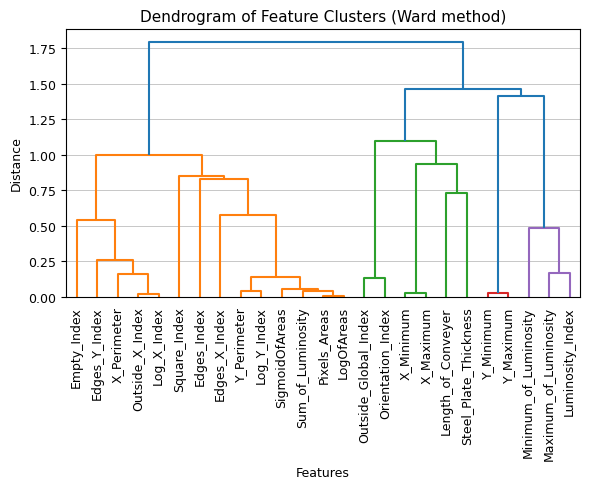

In [216]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd


# Convert the correlation matrix to a distance matrix (1 - correlation)
distance_matrix = 1 - corr.abs()

# Ensure the matrix is symmetric
distance_matrix = (distance_matrix + distance_matrix.T) / 2

# Set diagonal elements to zero (no self-distance)
np.fill_diagonal(distance_matrix.values, 0)

# Convert the symmetric distance matrix to a condensed format
condensed_distance = ssd.squareform(distance_matrix)

# Perform hierarchical clustering using the condensed distance matrix
linkage_method = 'ward'
linked = sch.linkage(condensed_distance, method=linkage_method, metric='correlation')



# Plot a dendrogram to visualize the clusters
plt.figure(figsize=(6, 5))
dendrogram = sch.dendrogram(linked, labels=corr.columns, leaf_rotation=90, leaf_font_size=9)
plt.title('Dendrogram of Feature Clusters (Ward method)', fontsize=11)
plt.xlabel('Features', fontsize=9)
plt.ylabel('Distance', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()


In [217]:
from scipy.cluster.hierarchy import fcluster

# Set a threshold distance for clusters
dist_thr = 0.15
clusters = fcluster(linked, dist_thr, criterion='distance')

# Create a dictionary to group features by clusters
cluster_dict = {}
for i, cluster_id in enumerate(clusters):
    feature = corr.columns[i]
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(feature)

# Display clusters of highly correlated features
print(f'Number of clusters: {len(cluster_dict)}\n')
for cluster_id, features in cluster_dict.items():
    print(f"Cluster {cluster_id}: {features}")


Number of clusters: 16

Cluster 10: ['X_Minimum', 'X_Maximum']
Cluster 13: ['Y_Minimum', 'Y_Maximum']
Cluster 5: ['Pixels_Areas', 'Y_Perimeter', 'Sum_of_Luminosity', 'LogOfAreas', 'Log_Y_Index', 'SigmoidOfAreas']
Cluster 2: ['X_Perimeter']
Cluster 16: ['Minimum_of_Luminosity']
Cluster 14: ['Maximum_of_Luminosity']
Cluster 11: ['Length_of_Conveyer']
Cluster 12: ['Steel_Plate_Thickness']
Cluster 7: ['Edges_Index']
Cluster 4: ['Empty_Index']
Cluster 8: ['Square_Index']
Cluster 1: ['Outside_X_Index', 'Log_X_Index']
Cluster 6: ['Edges_X_Index']
Cluster 3: ['Edges_Y_Index']
Cluster 9: ['Outside_Global_Index', 'Orientation_Index']
Cluster 15: ['Luminosity_Index']


In [218]:
# Select one feature from each cluster to keep
selected_num_features = [features[0] for features in cluster_dict.values()]
print(f'Number of selected numerical features: {len(selected_num_features)}')

Number of selected numerical features: 16


## Pre-Processing


### 1. Create Pipelines

In [219]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

cat_pipeline = 'passthrough'
num_pipeline = make_pipeline(StandardScaler())

preprocessing = ColumnTransformer([
    ('cat', cat_pipeline, ['TypeOfSteel_A300']),
    ('num', num_pipeline, selected_num_features)
])

### 2. Split Train Data

In [220]:
from sklearn.model_selection import train_test_split

features = selected_num_features + ['TypeOfSteel_A300']
X_train, X_val, y_train, y_val = train_test_split(train[features], target, test_size=0.2, random_state=7)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (15375, 17)
X_val shape: (3844, 17)
y_train shape: (15375, 7)
y_val shape: (3844, 7)


In [221]:
print(f'Number of missing values in X_train: {X_train.isna().sum().sum()}')
print(f'Number of missing values in X_val: {X_val.isna().sum().sum()}')
print(f'Number of missing values in y_train: {y_train.isna().sum().sum()}')
print(f'Number of missing values in y_val: {y_val.isna().sum().sum()}')
print()
print(f'Number of infinite values in X_train: {np.isinf(X_train).sum().sum()}')
print(f'Number of infinite values in X_val: {np.isinf(X_val).sum().sum()}')
print(f'Number of infinite values in y_train: {np.isinf(y_train).sum().sum()}')
print(f'Number of infinite values in y_val: {np.isinf(y_val).sum().sum()}')

Number of missing values in X_train: 0
Number of missing values in X_val: 0
Number of missing values in y_train: 0
Number of missing values in y_val: 0

Number of infinite values in X_train: 0
Number of infinite values in X_val: 0
Number of infinite values in y_train: 0
Number of infinite values in y_val: 0


## Multi-Output Classification

Since there are 7 targets, this is a multi-output classification problem, where each sample has multiple labels whose probabilities need to be predicted.

### 1. Hyperparameter Tuning with Bayesian Optimization

Bayesian Optimization is more efficient than Grid or Randomized Search because it uses past evaluations to decide on the next set of hyperparameters to try. Libraries like `hyperopt` and `optuna` are commonly used.

* __Handling Probabilities for ROC AUC Calculation across Multiple Labels__

    `cross_val_score` can directly compute scores using a single metric on each fold, but it does not return the individual fold predictions; it returns only the fold scores.
    To calculate a weighted AUC for multiple labels, we need access to the predicted probabilities across all labels for each sample in the entire dataset (as `roc_auc_score` requires actual probabilities for ROC AUC calculation).
    `cross_val_predict` with `predict_proba` provides these probabilities across all labels for every sample, allowing us to compute a custom score on the full set.

* __Compatibility with Multilabel Classification__

    For multilabel tasks, we need `predict_proba` for each label, so that we can calculate the AUC score per label and then average these for a final score.
    `cross_val_score` does not support returning probabilities for multiple outputs directly, while `cross_val_predict` can generate probabilistic predictions per label if we set `method='predict_proba'`.

In [222]:

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import roc_auc_score
from sklearn.multioutput import MultiOutputClassifier
import optuna






def is_by_label(best_params):
    return all(isinstance(value, dict) for value in best_params.values())


def make_model(base_model, best_params:dict, by_label:bool):
    base_model.set_params(**best_params)
    base_model_name = base_model.__class__.__name__
    if not by_label:
        model =  MultiOutputClassifier(base_model)
    else:
        model = base_model
    model = make_pipeline(preprocessing, model)
    return model


def optimize(base_model, param_space:dict, by_label:bool, save_to:str, **kwargs):
    
    n_trials = kwargs.get('n_trials', 100)
    n_splits = kwargs.get('n_splits', 3)
    n_startup_trials = kwargs.get('n_startup_trials', 5)
    n_warmup_steps = kwargs.get('n_warmup_steps', 1)
    interval_steps = kwargs.get('interval_steps', 1)
    n_jobs = kwargs.get('n_jobs', 1)
    
    pruner = optuna.pruners.MedianPruner(n_startup_trials, n_warmup_steps, interval_steps)
    study = optuna.create_study(direction="maximize", pruner=pruner)
    
    if by_label:
        best_params = lebal_specific_best_params(study, base_model, param_space, n_trials, n_splits, n_jobs)
    else:
        best_params = multilabel_best_params(study, base_model, param_space, n_trials, n_splits, n_jobs)
    
    save_params(best_params, save_to)




# Optimize multilabel best params
def multilabel_best_params(study:optuna.Study, base_model, param_sapce:dict, n_trials:int, n_splits:int, n_jobs:int):  
    optuna.logging.set_verbosity(optuna.logging.INFO)
    
    def objective(trial):
        
        params = param_sapce(trial)
        model = make_model(base_model, params, by_label=False)
        
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=7)
        y_pred_proba = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba', n_jobs=n_jobs)
        y_pred_proba_positive = np.array([y_pred_proba[i][:, 1] for i in range(len(y_pred_proba))]).T
        
        score = roc_auc_score(y_train, y_pred_proba_positive, average="weighted")
        
        trial.report(score, step=1)
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        return score
    
    study.optimize(objective, n_trials)

    print("Best Parameters:", study.best_params)
    print("Best AUC Score:", study.best_value)

    return study.best_params



# Optimize label-specific best params
def lebal_specific_best_params(study:optuna.Study, base_model, param_sapce, n_trials:int, n_splits:int, n_jobs=int):
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    
    best_params_by_label = {}
    for label in y_train.columns:

        def objective(trial):
            
            params = param_sapce(trial)
            model = make_model(base_model, params, by_label=True)
            
            cv = KFold(n_splits=n_splits, shuffle=True, random_state=7)
            y_pred_proba = cross_val_predict(model, X_train, y_train[label], cv=cv, method='predict_proba', n_jobs=n_jobs)
            y_pred_proba_positive = y_pred_proba[:, 1]
            
            score = roc_auc_score(y_train[label], y_pred_proba_positive)
            
            trial.report(score, step=1)
            if trial.should_prune():
                raise optuna.TrialPruned()
            
            return score

        study.optimize(objective, n_trials)
        best_params_by_label[label] = study.best_params
        
        print(f"Best Parameters for label {label}:", study.best_params)
        print(f"Best AUC Score for label {label}:", study.best_value)

    return best_params_by_label
    
    
def evaluate(base_model, best_param_file):
    best_params = load_params(best_param_file)
    by_label = is_by_label(best_params)
    
    if by_label:
        return evaluate_by_label(base_model, best_params)
    else:
        return evaluate_multilabel(base_model, best_params)



# Evalute model on validation set using multilabel best params
def evaluate_multilabel(base_model, best_params):
    
    model = make_model(base_model, best_params, by_label=False)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)
    y_pred_proba_positive = np.array([proba[:, 1] for proba in y_pred_proba]).T

    weighted_roc_auc_score = roc_auc_score(y_val, y_pred_proba_positive, average="weighted")
    print(f"Weighted ROC AUC Score on Validation Set: {weighted_roc_auc_score}")
    
    return weighted_roc_auc_score


# Evalute model on validation set using label-specific best params
def evaluate_by_label(base_model, best_params):
    
    y_pred_proba = pd.DataFrame(columns=y_val.columns)
    for label, params in best_params.items():

        print(f"Training model for label: '{label}'...")
        model = make_model(base_model, params, by_label=True)
        model.fit(X_train, y_train[label])
        
        y_pred_proba[label] = model.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val[label], y_pred_proba[label])
        print(f"ROC AUC Score for label '{label}': {auc:.4f}\n")

    weighted_roc_auc_score = roc_auc_score(y_val, y_pred_proba, average="weighted")
    print(f"Weighted ROC AUC Score on Validation Set: {weighted_roc_auc_score}")
    
    return weighted_roc_auc_score

### 2. Random Forest Classifier

#### 2.0. Basic Model
The `sklearn.RandomForestClassifier` supports multiclass-multioutput classification per [SciKit-Learn Documentation](https://scikit-learn.org/1.5/modules/multiclass.html).

In [310]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(random_state=7)
rf.fit(X_train, y_train)
y_pred_proba = rf.predict_proba(X_val)
print(f"'y_pred_proba' is of type {type(y_pred_proba)} with {len(y_pred_proba)} elements, each with shape {y_pred_proba[0].shape}\n")

y_pred_proba_positive = np.array([proba[:, 1] for proba in y_pred_proba]).T
print(f"ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_positive, average=None).round(3)}\n")
print(f"Weighted Average ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_positive, average='weighted').round(3)}")

'y_pred_proba' is of type <class 'list'> with 7 elements, each with shape (3844, 2)

ROC AUC Score on Validation Set: [0.855 0.958 0.981 0.984 0.89  0.801 0.684]

Weighted Average ROC AUC Score on Validation Set: 0.817


#### 2.1. Define Model and Parameter Space

In [146]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

def rf_param_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'random_state': 7,
        'n_jobs': -1
    }

#### 2.2. Multilabel Hyperparameter Tuning

In [147]:
# Tune the hyperparameters for multilabel
optimize(
    base_model=rf,
    param_space=rf_param_space,
    by_label=False,
    save_to='./models/rf_best_params_multi.json',
    n_trials=50,
    n_splits=3
)
    

[I 2024-11-11 17:07:15,189] A new study created in memory with name: no-name-258fff21-f932-4c09-b333-4ee1d3b6bdfe
[I 2024-11-11 17:07:41,246] Trial 0 finished with value: 0.8202314376755402 and parameters: {'n_estimators': 533, 'max_depth': 13, 'min_samples_split': 41, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.8202314376755402.
[I 2024-11-11 17:08:29,311] Trial 1 finished with value: 0.8201182618822926 and parameters: {'n_estimators': 933, 'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.8202314376755402.
[I 2024-11-11 17:09:07,087] Trial 2 finished with value: 0.8128572775821256 and parameters: {'n_estimators': 801, 'max_depth': 5, 'min_samples_split': 46, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8202314376755402.
[I 2024-11-11 17:09:41,116] Trial 3 finished with value: 0.8199689381319543 and parameters: {'n_estimators': 648, 'max_depth': 18, 'min_samples_split': 18, 'min_samples_leaf': 13}. Best is trial 0 with

Best Parameters: {'n_estimators': 714, 'max_depth': 14, 'min_samples_split': 24, 'min_samples_leaf': 16}
Best AUC Score: 0.8204499124351955
Best parameters saved to: './models/rf_best_params_multi.json'.


In [148]:
# Evaluate the model on the validation set using the multilabel best params
evaluate(rf, './models/rf_best_params_multi.json')

Parameters loaded from: './models/rf_best_params_multi.json'.
Weighted ROC AUC Score on Validation Set: 0.8265123824393189


0.8265123824393189

#### 2.3. Label-specific Hyperparameter Tuning

In [149]:
# Tune the hyperparameters for each label
optimize(
    base_model=rf,
    param_space=rf_param_space,
    by_label=True,
    save_to='./models/rf_best_params_label.json',
    n_trials=50,
    n_splits=3
)

[I 2024-11-11 17:40:18,615] A new study created in memory with name: no-name-14e4a04b-bc35-4454-96fd-ba3eba61c354


Best Parameters for label Pastry: {'n_estimators': 813, 'max_depth': 13, 'min_samples_split': 21, 'min_samples_leaf': 15}
Best AUC Score for label Pastry: 0.864448297004165
Best Parameters for label Z_Scratch: {'n_estimators': 898, 'max_depth': 12, 'min_samples_split': 47, 'min_samples_leaf': 13}
Best AUC Score for label Z_Scratch: 0.9496354228405454
Best Parameters for label K_Scatch: {'n_estimators': 909, 'max_depth': 14, 'min_samples_split': 38, 'min_samples_leaf': 16}
Best AUC Score for label K_Scatch: 0.9849668213269155
Best Parameters for label Stains: {'n_estimators': 704, 'max_depth': 17, 'min_samples_split': 40, 'min_samples_leaf': 19}
Best AUC Score for label Stains: 0.9902797005977771
Best Parameters for label Dirtiness: {'n_estimators': 704, 'max_depth': 17, 'min_samples_split': 40, 'min_samples_leaf': 19}
Best AUC Score for label Dirtiness: 0.9902797005977771
Best Parameters for label Bumps: {'n_estimators': 704, 'max_depth': 17, 'min_samples_split': 40, 'min_samples_leaf'

In [150]:
# Evaluate the model on the validation set using the single label best params
evaluate(rf, './models/rf_best_params_label.json')

Parameters loaded from: './models/rf_best_params_label.json'.
Training model for label: 'Pastry'...
ROC AUC Score for label 'Pastry': 0.8608

Training model for label: 'Z_Scratch'...
ROC AUC Score for label 'Z_Scratch': 0.9606

Training model for label: 'K_Scatch'...
ROC AUC Score for label 'K_Scatch': 0.9832

Training model for label: 'Stains'...
ROC AUC Score for label 'Stains': 0.9914

Training model for label: 'Dirtiness'...
ROC AUC Score for label 'Dirtiness': 0.8961

Training model for label: 'Bumps'...
ROC AUC Score for label 'Bumps': 0.8081

Training model for label: 'Other_Faults'...
ROC AUC Score for label 'Other_Faults': 0.7031

Weighted ROC AUC Score on Validation Set: 0.8267860895690299


0.8267860895690299

### 3. XGBoost Classifier

#### 3.0. Basic Model

According to [XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/tutorials/multioutput.html), starting from version 1.6, XGBoost can support multilabel classification with Python package meaning it can be used for targets that have multiple non-exclusive class labels.

In [309]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_proba = xgb.predict_proba(X_val)
print(f"'y_pred_proba' is of type {type(y_pred_proba)} of size {y_pred_proba.shape}\n")

print(f"ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba, average=None).round(3)}")
print(f"Weighted Average ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba, average='weighted').round(3)}")


'y_pred_proba' is of type <class 'numpy.ndarray'> of size (3844, 7)

ROC AUC Score on Validation Set: [0.843 0.955 0.983 0.992 0.859 0.787 0.677]
Weighted Average ROC AUC Score on Validation Set: 0.809


In [ ]:
# from xgboost import XGBClassifier

# param = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'booster': 'gbtree',
#     'device': 'gpu',
#     'seed': 7
# }

# imp_df = pd.DataFrame(index=train.columns)
# for col in target.columns:
#     xgb_clf = XGBClassifier(**param)
#     xgb_clf.fit(X_train, y_train[col])
#     imp_df[col] = xgb_clf.feature_importances_

In [ ]:
# imp_thr = 0.01
# print(f"Number of features selected for each target  with importance > {imp_thr}:\n")
# for col in target.columns:
#     # print(f'{col}:{imp_df[imp_df[col]>imp_thr][col].sort_values(ascending=False).index.tolist()}')
#     print(f'{col}: {len(imp_df[imp_df[col]>imp_thr][col].sort_values(ascending=False).index.tolist())}')



# ncols = 4
# nrows = ceil(len(target.columns)/ncols)
# fig, ax = plt.subplots(nrows, ncols, figsize=(15, 10))
# ax = ax.ravel()

# for i, col in enumerate(target.columns):
#     data = imp_df[col].sort_values(ascending=False)
#     sns.barplot(x=data, y=data.index, palette='flare', hue=data, ax=ax[i])
#     ax[i].set_title(f'{col}')
#     ax[i].set_ylabel('Features')
#     ax[i].set_xlabel('Importance')
    
# for j in range(i+1, len(ax)):
#     fig.delaxes(ax[j])
    
# plt.tight_layout()
# plt.show()

#### 3.1. Define Model and Parameter Space

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

def xgb_param_space(trial) -> dict:
    return {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'device': 'gpu',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'eta': trial.suggest_float('eta', 1e-2, 0.5),  # learning_rate
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 50.0),
        'gamma': trial.suggest_float('gamma',1e-2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-2, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-2, 1.0),
        'random_state': 7
    }

#### 3.2. Multilabel Hyperparameter Tuning

In [155]:
# Tune the hyperparameters for multilabel
optimize(
    base_model=xgb,
    param_space=xgb_param_space,
    by_label=False,
    save_to='./models/xgb_best_params_multi.json',
    n_trials=50,
    n_splits=3,
    n_jobs=-1
)

[I 2024-11-11 18:15:40,460] A new study created in memory with name: no-name-ef275aea-49ac-4c3b-b064-58515b9aa22f
[I 2024-11-11 18:16:13,589] Trial 0 finished with value: 0.7954277477938102 and parameters: {'n_estimators': 688, 'eta': 0.19326489003320765, 'max_depth': 5, 'min_child_weight': 24.64102588258905, 'gamma': 0.38785754698177877, 'subsample': 0.5724420798846513, 'colsample_bytree': 0.7428239846196116, 'lambda': 0.21536981197086322, 'alpha': 0.3302070478064835}. Best is trial 0 with value: 0.7954277477938102.
[I 2024-11-11 18:16:22,074] Trial 1 finished with value: 0.8185321533425703 and parameters: {'n_estimators': 130, 'eta': 0.12201579614346274, 'max_depth': 7, 'min_child_weight': 18.696737024921568, 'gamma': 0.8028177035886128, 'subsample': 0.9588300838728427, 'colsample_bytree': 0.5927168696158547, 'lambda': 0.5696946540427874, 'alpha': 0.6340199472144684}. Best is trial 1 with value: 0.8185321533425703.
[I 2024-11-11 18:16:49,458] Trial 2 finished with value: 0.8130079843

Best Parameters: {'n_estimators': 420, 'eta': 0.016394166018462407, 'max_depth': 3, 'min_child_weight': 1.358922642452007, 'gamma': 0.5809449193193349, 'subsample': 0.7271639769771057, 'colsample_bytree': 0.7095693379989159, 'lambda': 0.09466205935914307, 'alpha': 0.6375246008064082}
Best AUC Score: 0.8235886955623741
Best parameters saved to: './models/xgb_best_params_multi.json'.


In [156]:
# Evaluate the model on the validation set using the multilabel best params
evaluate(xgb, './models/xgb_best_params_multi.json')

Parameters loaded from: './models/xgb_best_params_multi.json'.
Weighted ROC AUC Score on Validation Set: 0.8269894350937451


0.8269894350937451

#### 3.3. Label-specific Hyperparameter Tuning

In [157]:
# Tune the hyperparameters for each label
optimize(
    base_model=xgb,
    param_space=xgb_param_space,
    by_label=True,
    save_to='./models/xgb_best_params_label.json',
    n_trials=50,
    n_splits=3,
    n_jobs=-1
)

[I 2024-11-11 18:30:54,204] A new study created in memory with name: no-name-99bcf1b5-ac6a-4eb8-bf69-e497e59424fc


Best Parameters for label Pastry: {'n_estimators': 362, 'eta': 0.011620496798978495, 'max_depth': 6, 'min_child_weight': 13.246666129769086, 'gamma': 0.08642251154553221, 'subsample': 0.7964273359243378, 'colsample_bytree': 0.5757798509508381, 'lambda': 0.8515808458461247, 'alpha': 0.527244005745701}
Best AUC Score for label Pastry: 0.8671194196192611
Best Parameters for label Z_Scratch: {'n_estimators': 641, 'eta': 0.07427072142546153, 'max_depth': 5, 'min_child_weight': 2.5156933935409556, 'gamma': 0.9973333434415823, 'subsample': 0.9734004611388201, 'colsample_bytree': 0.9224917785881819, 'lambda': 0.7692073706618019, 'alpha': 0.97664669635053}
Best AUC Score for label Z_Scratch: 0.9567027345127386
Best Parameters for label K_Scatch: {'n_estimators': 122, 'eta': 0.059889037152951075, 'max_depth': 5, 'min_child_weight': 32.40157278444019, 'gamma': 0.4340186625887647, 'subsample': 0.8127133694823049, 'colsample_bytree': 0.8294041954799877, 'lambda': 0.7741520866866541, 'alpha': 0.8781

In [158]:
# Evaluate the model on the validation set using the label-specific best params
evaluate(xgb, './models/xgb_best_params_label.json')

Parameters loaded from: './models/xgb_best_params_label.json'.
Training model for label: 'Pastry'...
ROC AUC Score for label 'Pastry': 0.8636

Training model for label: 'Z_Scratch'...
ROC AUC Score for label 'Z_Scratch': 0.9622

Training model for label: 'K_Scatch'...
ROC AUC Score for label 'K_Scatch': 0.9833

Training model for label: 'Stains'...
ROC AUC Score for label 'Stains': 0.9928

Training model for label: 'Dirtiness'...
ROC AUC Score for label 'Dirtiness': 0.8958

Training model for label: 'Bumps'...
ROC AUC Score for label 'Bumps': 0.8104

Training model for label: 'Other_Faults'...
ROC AUC Score for label 'Other_Faults': 0.7046

Weighted ROC AUC Score on Validation Set: 0.8282871264368881


0.8282871264368881

In [ ]:
# # Find the best parameters for each label independently (one set of parameters per label)

# import optuna
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer, roc_auc_score

# optuna.logging.set_verbosity(optuna.logging.ERROR)

# # Function to perform hyperparameter tuning for each label
# def tune_model_for_each_label(X_train, y_train, filename='best_params.json'):
#     best_params = {}
#     best_scores = {}

#     for label in y_train.columns:
#         print(f"Tuning for label '{label}'...")

#         # Define the objective function for Optuna
#         def objective(trial):

#             param = {
#                 'objective': 'binary:logistic',
#                 'eval_metric': 'auc',
#                 'booster': 'gbtree',
#                 'device': 'gpu',
#                 'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
#                 'eta': trial.suggest_float('eta', 1e-3, 0.1, log=True),  # learning_rate
#                 'max_depth': trial.suggest_int('max_depth', 2, 10),
#                 'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
#                 'gamma': trial.suggest_float('gamma', 0, 1.0),
#                 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#                 'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True),
#                 'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True),
#                 'random_state': 7
#             }

#             model = Pipeline(steps=[
#                 ('prep', StandardScaler()),
#                 ('clf', xgb.XGBClassifier(**param))
#             ])
            
#             auc_scorer = make_scorer(roc_auc_score)
                       
#             scores = cross_val_score(model, X_train, y_train[label], cv=5, scoring=auc_scorer)

#             return scores.mean()

#         # Create a study and optimize it
#         study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=7))
#         study.optimize(objective, n_trials=100)

#         best_params[label] = study.best_params
#         best_scores[label] = study.best_value

#         print(f"Best Parameters for {label}: {study.best_params}")
#         print(f"Best AUC Score for {label}: {study.best_value}\n")
    
#     save_params(best_params, filename)
    
#     return best_params, best_scores


# best_params, best_scores = tune_model_for_each_label(X_train, y_train, filename='xgb_best_params_labels_1.json')


In [ ]:
# # Evalute the model on the validation set (by label)

# xgb = xgb.XGBClassifier(random_state=7)
# auc = evaluate_by_label(xgb, 'xgb_best_params_labels_1.json')

In [ ]:
# # One set of best params for all labels

# import optuna
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer, roc_auc_score
# from sklearn.multioutput import MultiOutputClassifier


# optuna.logging.set_verbosity(optuna.logging.INFO)


# def objective(trial):

#     param = {
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'booster': 'gbtree',
#         'device': 'gpu',
#         'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
#         'eta': trial.suggest_float('eta', 1e-2, 1.0, log=True),  # learning_rate
#         'max_depth': trial.suggest_int('max_depth', 2, 10),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
#         'gamma': trial.suggest_float('gamma', 0, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True),
#         'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True), 
#     }

#     xgb = xgb.XGBClassifier(random_state= 7, **param)
#     model = MultiOutputClassifier(xgb)

#     cv = KFold(n_splits=5, shuffle=True, random_state=7)
#     y_pred_proba = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')
    
#     auc_scorer = make_scorer(roc_auc_score, average='weighted', multi_class='ovr')
                
#     scores = cross_val_score(model, X_train[features], y_train, cv=3, scoring=auc_scorer)

#     return scores.mean()


# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=7))
# study.optimize(objective, n_trials=100)

# print("Best Parameters: ", study.best_params)
# print("Best AUC Score: ", study.best_value)

# save_params(study.best_params, 'xgb_best_params_all_2.json')

In [ ]:
# # Evalute the model on the validation set (all labels)

# xgb = xgb.XGBClassifier(random_state=7)
# wrapper = MultiOutputClassifier
# auc = evaluate_all(xgb, 'xgb_best_params_all_1.json', wrapper)

### 4. LightGBM

#### 4.0. Besic Model
The `lightgbm.LGBMClassifier` does not support multilabel classification. As a result a wrapper is needed for this model where the target is multilabel. Two wrappers compared below, `MultiOutputClassifier` and `OneVsRestClassifier`.

Both are suitable, as they do not account for dependencies between labels. However, if dependency modeling is needed, alternative approaches like `sklearn.multioutput.ClassifierChain` would be more suitable.

* __`OneVsRestClassifier`__

    Originally designed for multiclass classification, where each class label is treated as a binary classification problem. For multilabel tasks, it treats each label as an independent binary classification problem.

    Each model is trained to distinguish between one specific label and all other labels combined. In a multilabel context, this approach is effective, as each label can be independently "on" or "off" without depending on other labels.

    Treats each label as fully independent. This can work well for multilabel problems, especially if each label is indeed independent of the others.

    Trains a separate binary classifier for each label, which may be more efficient if the underlying model has optimized support for binary classification.

    It can sometimes be faster and more memory-efficient in binary classification-focused tasks compared to `MultiOutputClassifier`.

* __`MultiOutputClassifier`__

    Created for multioutput tasks, where the outputs can be either binary or multiclass. Each output is predicted independently, making it general-purpose for both multioutput and multilabel use cases. Works well when each output (label) can be modeled independently, like in multilabel classification.

    Similarly treats labels as independent, though it is explicitly designed to handle multiple target outputs in both binary and multiclass contexts.

    Also trains one classifier per label, but the overhead might be slightly higher if it is not well-optimized for binary-only tasks. In practice, the difference is often minimal but can vary depending on the specific model used.

Both wrappers resulted in the same result in terms of ROC AUC score. The target analysis that is performed in earlier section, shows that the targets are independent, so no need to use `ClassifierChain`. Since `OneVsRestClassifier` performs slightly more efficient, it is used for this modeling.


In [360]:
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

lgb = LGBMClassifier(random_state=7)
lgb_moc = MultiOutputClassifier(lgb)
lgb_ovr = OneVsRestClassifier(lgb)

lgb_moc.fit(X_train, y_train)
lgb_ovr.fit(X_train, y_train)

print("MultiOutputClassifier:")
y_pred_proba_moc = lgb_moc.predict_proba(X_val)
y_pred_proba_moc_positive = np.array([proba[:, 1] for proba in y_pred_proba_moc]).T
print(f"'y_pred_proba_moc' is of type {type(y_pred_proba_moc)} with {len(y_pred_proba_moc)} each of shape {y_pred_proba_moc[0].shape}")
print(f"ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_moc_positive, average=None).round(3)}")
print(f"Weighted Average ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_moc_positive, average='weighted').round(3)}\n")

print("OneVsRestClassifier:")
y_pred_proba_ovr = lgb_ovr.predict_proba(X_val)
print(f"'y_pred_proba_ovr' is of type {type(y_pred_proba_ovr)} of size {y_pred_proba_ovr.shape}")
print(f"ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_ovr, average=None).round(3)}")
print(f"Weighted Average ROC AUC Score on Validation Set: {roc_auc_score(y_val, y_pred_proba_ovr, average='weighted').round(3)}")

MultiOutputClassifier:
'y_pred_proba_moc' is of type <class 'list'> with 7 each of shape (3844, 2)
ROC AUC Score on Validation Set: [0.853 0.961 0.983 0.992 0.889 0.808 0.702]
Weighted Average ROC AUC Score on Validation Set: 0.826

OneVsRestClassifier:
'y_pred_proba_ovr' is of type <class 'numpy.ndarray'> of size (3844, 7)
ROC AUC Score on Validation Set: [0.853 0.961 0.983 0.992 0.889 0.808 0.702]
Weighted Average ROC AUC Score on Validation Set: 0.826


#### 4.1. Define Model and Parameter Space

In [164]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier()

def lgb_param_space(trial) -> dict:
    return {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'device_type': 'gpu',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.5),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'pos_bagging_fraction': trial.suggest_float('pos_bagging_fraction', 0.5, 1.0),
        'neg_bagging_fraction': trial.suggest_float('neg_bagging_fraction', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1.0),
        'verbose': -1
    }

#### 4.2. Multilabel Hyperparameter Tuning

In [165]:
# Tune the hyperparameters for multilabel
optimize(
    base_model=lgb,
    param_space=lgb_param_space,
    by_label=False,
    save_to='./models/lgb_best_params_multi.json',
    n_trials=50,
    n_splits=3,
    n_jobs=-1
)

[I 2024-11-11 19:19:31,856] A new study created in memory with name: no-name-b9f11f01-ba9f-402e-b94b-b880b6ae6300
[I 2024-11-11 19:19:39,947] Trial 0 finished with value: 0.8087351895626328 and parameters: {'n_estimators': 577, 'num_leaves': 3, 'learning_rate': 0.42407881281216275, 'max_depth': 3, 'pos_bagging_fraction': 0.5151257094801751, 'neg_bagging_fraction': 0.5562694874155447, 'reg_alpha': 0.24855363365580463, 'reg_lambda': 0.35545669040935424}. Best is trial 0 with value: 0.8087351895626328.
[I 2024-11-11 19:19:45,509] Trial 1 finished with value: 0.8093122225446309 and parameters: {'n_estimators': 315, 'num_leaves': 100, 'learning_rate': 0.4399030058611783, 'max_depth': 2, 'pos_bagging_fraction': 0.7685127694435332, 'neg_bagging_fraction': 0.9105459438690023, 'reg_alpha': 0.11152355364864858, 'reg_lambda': 0.7111170354295057}. Best is trial 1 with value: 0.8093122225446309.
[I 2024-11-11 19:20:00,760] Trial 2 finished with value: 0.8224662391855669 and parameters: {'n_estimato

Best Parameters: {'n_estimators': 995, 'num_leaves': 8, 'learning_rate': 0.012378017411695115, 'max_depth': 9, 'pos_bagging_fraction': 0.7161400681260875, 'neg_bagging_fraction': 0.8910667721935428, 'reg_alpha': 0.4645207180543134, 'reg_lambda': 0.6789612596287089}
Best AUC Score: 0.8236452374821288
Best parameters saved to: './models/lgb_best_params_multi.json'.


In [166]:
# Evaluate the model on the validation set using the multilabel best params
evaluate(lgb, './models/lgb_best_params_multi.json')

Parameters loaded from: './models/lgb_best_params_multi.json'.
Weighted ROC AUC Score on Validation Set: 0.8279461679609599


0.8279461679609599

#### 4.3. Label-Specific Hyperparameter Tuning

In [167]:
# Tune the hyperparameters for each label
optimize(
    base_model=lgb,
    param_space=lgb_param_space,
    by_label=True,
    save_to='./models/lgb_best_params_label.json',
    n_trials=50,
    n_splits=3,
    n_jobs=-1
)

[I 2024-11-11 19:49:47,065] A new study created in memory with name: no-name-326ce71a-2a13-4fc2-a5ec-6c2b66259d7c


Best Parameters for label Pastry: {'n_estimators': 883, 'num_leaves': 88, 'learning_rate': 0.01087684421763032, 'max_depth': 4, 'pos_bagging_fraction': 0.6071393520130943, 'neg_bagging_fraction': 0.878525956673947, 'reg_alpha': 0.7943652693707443, 'reg_lambda': 0.6554641544605125}
Best AUC Score for label Pastry: 0.8644044422564052
Best Parameters for label Z_Scratch: {'n_estimators': 278, 'num_leaves': 3, 'learning_rate': 0.23194457434801136, 'max_depth': 10, 'pos_bagging_fraction': 0.8289597936259416, 'neg_bagging_fraction': 0.6272001725534, 'reg_alpha': 0.5177313368412074, 'reg_lambda': 0.028244876534295346}
Best AUC Score for label Z_Scratch: 0.9561377612334732
Best Parameters for label K_Scatch: {'n_estimators': 108, 'num_leaves': 4, 'learning_rate': 0.293362085728047, 'max_depth': 7, 'pos_bagging_fraction': 0.7257632741534299, 'neg_bagging_fraction': 0.7187182708107342, 'reg_alpha': 0.6155802994003394, 'reg_lambda': 0.04538266222405765}
Best AUC Score for label K_Scatch: 0.984310

In [168]:
# Evaluate the model on the validation set using the label-specific best params
evaluate(lgb, './models/lgb_best_params_label.json')

Parameters loaded from: './models/lgb_best_params_label.json'.
Training model for label: 'Pastry'...
ROC AUC Score for label 'Pastry': 0.8646

Training model for label: 'Z_Scratch'...
ROC AUC Score for label 'Z_Scratch': 0.9636

Training model for label: 'K_Scatch'...
ROC AUC Score for label 'K_Scatch': 0.9830

Training model for label: 'Stains'...
ROC AUC Score for label 'Stains': 0.9918

Training model for label: 'Dirtiness'...
ROC AUC Score for label 'Dirtiness': 0.8699

Training model for label: 'Bumps'...
ROC AUC Score for label 'Bumps': 0.8017

Training model for label: 'Other_Faults'...
ROC AUC Score for label 'Other_Faults': 0.6909

Weighted ROC AUC Score on Validation Set: 0.8206434709563987


0.8206434709563987

## Ensamble

In [238]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


rf_best_params = load_params('./models/rf_best_params_multi.json')
xgb_best_params = load_params('./models/xgb_best_params_multi.json')
lgb_best_params = load_params('./models/lgb_best_params_multi.json')

  
rf_best_params_label = load_params('./models/rf_best_params_label.json')
xgb_best_params_label = load_params('./models/xgb_best_params_label.json')
lgb_best_params_label = load_params('./models/lgb_best_params_label.json')
 
    
# Retrieve the best classifiers for each label
def get_classifiers_for_label(label):
    rf = RandomForestClassifier(**rf_best_params_label[label])
    xgb = XGBClassifier(**xgb_best_params_label[label])
    lgb = LGBMClassifier(**lgb_best_params_label[label])
    return rf, xgb, lgb


# Retrieve the best classifiers for each label
def get_classifiers():
    rf = RandomForestClassifier(**rf_best_params)
    xgb = XGBClassifier(**xgb_best_params)
    lgb = LGBMClassifier(**lgb_best_params)
    return rf, xgb, lgb

Parameters loaded from: './models/rf_best_params_multi.json'.
Parameters loaded from: './models/xgb_best_params_multi.json'.
Parameters loaded from: './models/lgb_best_params_multi.json'.
Parameters loaded from: './models/rf_best_params_label.json'.
Parameters loaded from: './models/xgb_best_params_label.json'.
Parameters loaded from: './models/lgb_best_params_label.json'.


### 1. Voting

#### 1.1. Multilabel Weight-Tuning Using Label-Specific Hyper-Params

In [ ]:
import optuna
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict


N_SPLITS = 3
N_TRIALS = 50
N_JOBS = -1



def objective(trial):
    weights = [
        trial.suggest_float("weight_rf", 0.01, 1.0),
        trial.suggest_float("weight_xgb", 0.01, 1.0),
        trial.suggest_float("weight_lgb", 0.01, 1.0)
    ]

    auc_scores = []
    
    for label in y_train.columns:
        rf, xgb, lgb = get_classifiers_for_label(label)

        voting_clf = VotingClassifier(
            estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb)],
            voting='soft',
            weights=weights
        )
        
        cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=7)

        y_pred_proba = cross_val_predict(
            voting_clf, X_train, y_train[label],
            cv=cv, method='predict_proba', n_jobs=N_JOBS
        )[:, 1] # positive class probabilities
        
        # Calculate the AUC score for the label
        auc = roc_auc_score(y_train[label], y_pred_proba)
        auc_scores.append(auc)
        
        # Report intermediate AUC score for the pruner
        trial.report(auc, step=label)

        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Return the average AUC score across labels as the optimization objective
    return np.mean(auc_scores)



optuna.logging.set_verbosity(optuna.logging.INFO)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)
sampler = optuna.samplers.TPESampler(seed=7)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=N_TRIALS)



print(f"Best weights: {study.best_params}")
print(f"Best average ROC AUC score: {study.best_value}")

filename = './models/voting_clf_best_weights_multi_hyperparams.json'
save_params(study.best_params, filename)


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score


best_weights = load_params('./models/voting_clf_best_weights.json')

auc_scores = []
weights = []

for label in y_val.columns:

    rf, xgb, lgb = get_classifiers_for_label(label)
    
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb)],
        voting='soft',
        weights=[best_weights['weight_rf'], best_weights['weight_xgb'], best_weights['weight_lgb']]
    )

    voting_clf.fit(X_train, y_train[label])

    y_pred_proba = voting_clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val[label], y_pred_proba)
    auc_scores.append(auc)

    positive_count = y_val[label].sum()
    weights.append(positive_count)

weighted_average_auc_score = np.average(auc_scores, weights=weights)
print(f"Weighted Average ROC AUC Score on Validation Set: {weighted_average_auc_score:.4f}")

Weighted Average ROC AUC Score on Validation Set: 0.8302


#### 1.2. Multilabel Weight-Tuning Using Multilabel Hyper-Params

In [ ]:
import optuna
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.multiclass import OneVsRestClassifier

N_SPLITS = 3
N_TRIALS = 20
N_JOBS = -1



def objective(trial):
    weights = [
        trial.suggest_float("weight_rf", 0.01, 1.0),
        trial.suggest_float("weight_xgb", 0.01, 1.0),
        trial.suggest_float("weight_lgb", 0.01, 1.0)
    ]

    
    rf, xgb, lgb = get_classifiers()

    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb)],
        voting='soft',
        weights=weights
    )
    
    multilabel_clf = OneVsRestClassifier(voting_clf, n_jobs=N_JOBS)
    
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=7)
    fold_aucs = []
    
    # Iterate over each fold
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        # Use .iloc to properly index rows by position
        multilabel_clf.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        y_pred_proba = multilabel_clf.predict_proba(X_train.iloc[val_idx])

        fold_auc = roc_auc_score(y_train.iloc[val_idx], y_pred_proba, average='weighted')
        fold_aucs.append(fold_auc)
        
        # Report intermediate AUC to Optuna
        trial.report(fold_auc, fold_idx)
        
        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Return the mean AUC across folds
    return np.mean(fold_aucs)



optuna.logging.set_verbosity(optuna.logging.INFO)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)
sampler = optuna.samplers.TPESampler(seed=7)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=N_TRIALS)



print(f"Best weights: {study.best_params}")
print(f"Best average ROC AUC score: {study.best_value}")

save_params(study.best_params, './models/voting_clf_best_weights_multi_hyperparams.json')


[I 2024-11-12 11:43:50,238] A new study created in memory with name: no-name-b8bb425c-8a10-4f0a-80f6-93a2ffd13094
[I 2024-11-12 11:44:36,743] Trial 0 finished with value: 0.825016000339419 and parameters: {'weight_rf': 0.0855452064802176, 'weight_xgb': 0.7821196043177134, 'weight_lgb': 0.44402513912648456}. Best is trial 0 with value: 0.825016000339419.
[I 2024-11-12 11:45:35,828] Trial 1 finished with value: 0.824840012062468 and parameters: {'weight_rf': 0.7262305260526318, 'weight_xgb': 0.9782096168766367, 'weight_lgb': 0.5431109117063293}. Best is trial 0 with value: 0.825016000339419.
[I 2024-11-12 11:46:34,210] Trial 2 finished with value: 0.8242058373249467 and parameters: {'weight_rf': 0.5061092590233385, 'weight_xgb': 0.08133062202616392, 'weight_lgb': 0.2757545903008525}. Best is trial 0 with value: 0.825016000339419.
[I 2024-11-12 11:47:26,451] Trial 3 finished with value: 0.8251409065767309 and parameters: {'weight_rf': 0.5048836758173043, 'weight_xgb': 0.682437696159731, '

Best weights: {'weight_rf': 0.5048836758173043, 'weight_xgb': 0.682437696159731, 'weight_lgb': 0.8057016457433317}
Best average ROC AUC score: 0.8251409065767309
Best parameters saved to: './models/voting_clf_best_weights_multi_hyperparams.json'.


In [256]:
load_params('./models/voting_clf_best_weights_multi_hyperparams.json')


Parameters loaded from: './models/voting_clf_best_weights_multi_hyperparams.json'.


{'weight_rf': 0.5048836758173043,
 'weight_xgb': 0.682437696159731,
 'weight_lgb': 0.8057016457433317}

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score


best_weights = load_params('./models/voting_clf_best_weights_multi_hyperparams.json')


rf, xgb, lgb = get_classifiers()

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb)],
    voting='soft',
    weights=[best_weights['weight_rf'], best_weights['weight_xgb'], best_weights['weight_lgb']]
)

multilabel_clf = OneVsRestClassifier(voting_clf, n_jobs=N_JOBS)
multilabel_clf.fit(X_train, y_train)

y_pred_proba = multilabel_clf.predict_proba(X_val)
weighted_average_auc_score = roc_auc_score(y_val, y_pred_proba, average='weighted')


print(f"Weighted Average ROC AUC Score on Validation Set: {weighted_average_auc_score:.4f}")

Parameters loaded from: './models/voting_clf_best_weights_multi_hyperparams.json'.
Weighted Average ROC AUC Score on Validation Set: 0.8295


#### 1.3. Label-Specific Weight-Tuning Using Label-Specific Hyper-Params

In [225]:
import optuna
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import roc_auc_score


N_SPLITS = 3
N_TRIALS = 50
N_JOBS = -1


# Objective function that accepts a specific label
def objective(trial, label):
    # Define label-specific weights
    weights = [
        trial.suggest_float(f"weight_rf_{label}", 0.01, 1.0),
        trial.suggest_float(f"weight_xgb_{label}", 0.01, 1.0),
        trial.suggest_float(f"weight_lgb_{label}", 0.01, 1.0)
    ]
    
    # Get classifiers for the current label
    rf, xgb, lgb = get_classifiers_for_label(label)

    # Initialize the VotingClassifier with label-specific weights
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb)],
        voting='soft',
        weights=weights
    )

    # Perform cross-validation
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=7)
    auc_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train[label])):
        # Split the data for the current fold
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[label].iloc[train_idx], y_train[label].iloc[val_idx]
        
        # Fit and predict on the current fold
        voting_clf.fit(X_train_fold, y_train_fold)
        y_pred_proba = voting_clf.predict_proba(X_val_fold)[:, 1]
        
        # Calculate AUC score for the current fold
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)
        
        # Report intermediate AUC score for the current fold to the pruner
        trial.report(auc, fold_idx)
        
        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Return the average AUC score across folds as the optimization objective
    return np.mean(auc_scores)


# Setting up Optuna for each label
optuna.logging.set_verbosity(optuna.logging.INFO)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)
sampler = optuna.samplers.TPESampler(seed=7)
label_weights = {}
average_auc_scores = []

# Optimize weights separately for each label
for label in y_train.columns:
    print(f"Optimizing weights for label: {label}")
    study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
    study.optimize(lambda trial: objective(trial, label), n_trials=N_TRIALS)
    
    # Store the best weights and AUC for each label
    best_trial = study.best_trial
    label_weights[label] = {
        'rf_weight': best_trial.params[f"weight_rf_{label}"],
        'xgb_weight': best_trial.params[f"weight_xgb_{label}"],
        'lgb_weight': best_trial.params[f"weight_lgb_{label}"]
    }
    average_auc_scores.append(study.best_value)

print("\nOptimized weights per label:")
for label, weights in label_weights.items():
    print(f"Label {label}: {weights}")

print(f"\nAverage ROC AUC score across labels: {np.mean(average_auc_scores)}")


save_params(label_weights, './models/voting_clf_best_weights_label.json')


[I 2024-11-12 07:57:45,277] A new study created in memory with name: no-name-28e4c3ba-be58-48ce-ad3a-70e4be33eb2f


Optimizing weights for label: Pastry


[I 2024-11-12 07:58:09,166] Trial 0 finished with value: 0.8680455829897973 and parameters: {'weight_rf_Pastry': 0.0855452064802176, 'weight_xgb_Pastry': 0.7821196043177134, 'weight_lgb_Pastry': 0.44402513912648456}. Best is trial 0 with value: 0.8680455829897973.
[I 2024-11-12 07:58:33,173] Trial 1 finished with value: 0.8680510015720717 and parameters: {'weight_rf_Pastry': 0.7262305260526318, 'weight_xgb_Pastry': 0.9782096168766367, 'weight_lgb_Pastry': 0.5431109117063293}. Best is trial 1 with value: 0.8680510015720717.
[I 2024-11-12 07:58:57,168] Trial 2 finished with value: 0.8671585348019137 and parameters: {'weight_rf_Pastry': 0.5061092590233385, 'weight_xgb_Pastry': 0.08133062202616392, 'weight_lgb_Pastry': 0.2757545903008525}. Best is trial 1 with value: 0.8680510015720717.
[I 2024-11-12 07:59:21,301] Trial 3 finished with value: 0.8680143825543314 and parameters: {'weight_rf_Pastry': 0.5048836758173043, 'weight_xgb_Pastry': 0.682437696159731, 'weight_lgb_Pastry': 0.8057016457

Optimizing weights for label: Z_Scratch


[I 2024-11-12 08:13:50,337] Trial 0 finished with value: 0.9581618061828876 and parameters: {'weight_rf_Z_Scratch': 0.21280059939481713, 'weight_xgb_Z_Scratch': 0.49585823020015973, 'weight_lgb_Z_Scratch': 0.3786608424912084}. Best is trial 0 with value: 0.9581618061828876.
[I 2024-11-12 08:14:14,084] Trial 1 finished with value: 0.9576429372610753 and parameters: {'weight_rf_Z_Scratch': 0.48262714330307255, 'weight_xgb_Z_Scratch': 0.37223148192278704, 'weight_lgb_Z_Scratch': 0.8395388143661681}. Best is trial 0 with value: 0.9581618061828876.
[I 2024-11-12 08:14:37,841] Trial 2 finished with value: 0.9565306311144374 and parameters: {'weight_rf_Z_Scratch': 0.7709610314543142, 'weight_xgb_Z_Scratch': 0.32085473044053553, 'weight_lgb_Z_Scratch': 0.5768990793175145}. Best is trial 0 with value: 0.9581618061828876.
[I 2024-11-12 08:15:01,663] Trial 3 finished with value: 0.9577657204946904 and parameters: {'weight_rf_Z_Scratch': 0.28328855784738816, 'weight_xgb_Z_Scratch': 0.4583145032209

Optimizing weights for label: K_Scatch


[I 2024-11-12 08:37:10,333] Trial 0 finished with value: 0.9856613782101288 and parameters: {'weight_rf_K_Scatch': 0.9559136397728967, 'weight_xgb_K_Scatch': 0.6860847158316633, 'weight_lgb_K_Scatch': 0.06259740376622798}. Best is trial 0 with value: 0.9856613782101288.
[I 2024-11-12 08:37:46,919] Trial 1 finished with value: 0.9858679761745881 and parameters: {'weight_rf_K_Scatch': 0.31576415801515917, 'weight_xgb_K_Scatch': 0.5966687404501392, 'weight_lgb_K_Scatch': 0.24276920318488968}. Best is trial 1 with value: 0.9858679761745881.
[I 2024-11-12 08:38:18,801] Trial 2 finished with value: 0.9859523976885621 and parameters: {'weight_rf_K_Scatch': 0.9653212895407656, 'weight_xgb_K_Scatch': 0.9455977415548659, 'weight_lgb_K_Scatch': 0.8499168720293119}. Best is trial 2 with value: 0.9859523976885621.
[I 2024-11-12 08:38:44,708] Trial 3 finished with value: 0.9857676883264833 and parameters: {'weight_rf_K_Scatch': 0.47760075632551824, 'weight_xgb_K_Scatch': 0.8430619477494133, 'weight_

Optimizing weights for label: Stains


[I 2024-11-12 09:01:49,736] Trial 0 finished with value: 0.99142128014817 and parameters: {'weight_rf_Stains': 0.802474258508479, 'weight_xgb_Stains': 0.9397202401948634, 'weight_lgb_Stains': 0.05024925134231893}. Best is trial 0 with value: 0.99142128014817.
[I 2024-11-12 09:02:12,898] Trial 1 finished with value: 0.9912539055492099 and parameters: {'weight_rf_Stains': 0.8769150076213824, 'weight_xgb_Stains': 0.28379744172662286, 'weight_lgb_Stains': 0.4810068544300018}. Best is trial 0 with value: 0.99142128014817.
[I 2024-11-12 09:02:36,171] Trial 2 finished with value: 0.9914059441742888 and parameters: {'weight_rf_Stains': 0.7987933473625832, 'weight_xgb_Stains': 0.7200698099524777, 'weight_lgb_Stains': 0.1556760962222761}. Best is trial 0 with value: 0.99142128014817.
[I 2024-11-12 09:02:59,270] Trial 3 finished with value: 0.9911695477717996 and parameters: {'weight_rf_Stains': 0.662160776364604, 'weight_xgb_Stains': 0.0785595493097371, 'weight_lgb_Stains': 0.36349992206935017}.

Optimizing weights for label: Dirtiness


[I 2024-11-12 09:19:48,203] Trial 0 finished with value: 0.8827745305351026 and parameters: {'weight_rf_Dirtiness': 0.23183785057685616, 'weight_xgb_Dirtiness': 0.5791139617132576, 'weight_lgb_Dirtiness': 0.17782848633054707}. Best is trial 0 with value: 0.8827745305351026.
[I 2024-11-12 09:20:16,105] Trial 1 finished with value: 0.8818213985654481 and parameters: {'weight_rf_Dirtiness': 0.7844078498105405, 'weight_xgb_Dirtiness': 0.8584058698506426, 'weight_lgb_Dirtiness': 0.04333746245781971}. Best is trial 0 with value: 0.8827745305351026.
[I 2024-11-12 09:20:44,249] Trial 2 finished with value: 0.8821616113581686 and parameters: {'weight_rf_Dirtiness': 0.5373183568942369, 'weight_xgb_Dirtiness': 0.7989818438691287, 'weight_lgb_Dirtiness': 0.9753882843455446}. Best is trial 0 with value: 0.8827745305351026.
[I 2024-11-12 09:21:12,352] Trial 3 finished with value: 0.8793079435764332 and parameters: {'weight_rf_Dirtiness': 0.28151600726247705, 'weight_xgb_Dirtiness': 0.177410052731729

Optimizing weights for label: Bumps


[I 2024-11-12 09:39:48,109] Trial 0 finished with value: 0.8020936296057671 and parameters: {'weight_rf_Bumps': 0.03295846441836853, 'weight_xgb_Bumps': 0.5294726384009456, 'weight_lgb_Bumps': 0.6997289431675188}. Best is trial 0 with value: 0.8020936296057671.
[I 2024-11-12 09:40:10,441] Trial 1 finished with value: 0.8039530099978881 and parameters: {'weight_rf_Bumps': 0.43278295808359035, 'weight_xgb_Bumps': 0.14322475405824078, 'weight_lgb_Bumps': 0.3380436388527816}. Best is trial 1 with value: 0.8039530099978881.
[I 2024-11-12 09:40:32,901] Trial 2 finished with value: 0.8042932621205225 and parameters: {'weight_rf_Bumps': 0.5944423957632717, 'weight_xgb_Bumps': 0.9412547794624242, 'weight_lgb_Bumps': 0.9926321419809139}. Best is trial 2 with value: 0.8042932621205225.
[I 2024-11-12 09:40:55,520] Trial 3 finished with value: 0.7980257064629569 and parameters: {'weight_rf_Bumps': 0.24918688748731133, 'weight_xgb_Bumps': 0.020474107868962303, 'weight_lgb_Bumps': 0.8323339227338666}

Optimizing weights for label: Other_Faults


[I 2024-11-12 09:55:07,100] Trial 0 finished with value: 0.6986399791685481 and parameters: {'weight_rf_Other_Faults': 0.5396418433186365, 'weight_xgb_Other_Faults': 0.3238734431168342, 'weight_lgb_Other_Faults': 0.7397171789567678}. Best is trial 0 with value: 0.6986399791685481.
[I 2024-11-12 09:55:31,872] Trial 1 finished with value: 0.6981069432815007 and parameters: {'weight_rf_Other_Faults': 0.16860038651297782, 'weight_xgb_Other_Faults': 0.20058313677025683, 'weight_lgb_Other_Faults': 0.36096590786515}. Best is trial 0 with value: 0.6986399791685481.
[I 2024-11-12 09:55:56,967] Trial 2 finished with value: 0.6959068256189987 and parameters: {'weight_rf_Other_Faults': 0.3845923720971051, 'weight_xgb_Other_Faults': 0.2142229979356478, 'weight_lgb_Other_Faults': 0.9195221130908454}. Best is trial 0 with value: 0.6986399791685481.
[I 2024-11-12 09:56:22,014] Trial 3 finished with value: 0.7007291209415571 and parameters: {'weight_rf_Other_Faults': 0.8298126338514781, 'weight_xgb_Oth


Optimized weights per label:
Label Pastry: {'rf_weight': 0.17470937402435732, 'xgb_weight': 0.5970706817008745, 'lgb_weight': 0.21490490983058463}
Label Z_Scratch: {'rf_weight': 0.13614690162057935, 'xgb_weight': 0.6538654258206478, 'lgb_weight': 0.6466370405286214}
Label K_Scatch: {'rf_weight': 0.9252265740532455, 'xgb_weight': 0.7402211068354122, 'lgb_weight': 0.8306425073332967}
Label Stains: {'rf_weight': 0.012214539269219836, 'xgb_weight': 0.5486924246074745, 'lgb_weight': 0.33496723426962327}
Label Dirtiness: {'rf_weight': 0.21722885247653814, 'xgb_weight': 0.8673486952688398, 'lgb_weight': 0.4180755724611329}
Label Bumps: {'rf_weight': 0.27922764573854936, 'xgb_weight': 0.7565682245094631, 'lgb_weight': 0.02784563380619015}
Label Other_Faults: {'rf_weight': 0.9450633970025545, 'xgb_weight': 0.9902677489906503, 'lgb_weight': 0.013417945955714557}

Average ROC AUC score across labels: 0.8853788616472221
Best parameters saved to: './models/voting_clf_best_weights_label.json'.


In [226]:
import json
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

best_weights = load_params('./models/voting_clf_best_weights_label.json')

auc_scores = []
weights = []

for label in y_val.columns:
    # Retrieve label-specific weights
    label_weights = [
        best_weights[label]['rf_weight'],
        best_weights[label]['xgb_weight'],
        best_weights[label]['lgb_weight']
    ]

    # Get classifiers for the current label
    rf, xgb, lgb = get_classifiers_for_label(label)

    # Initialize the VotingClassifier with label-specific weights
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb)],
        voting='soft',
        weights=label_weights
    )

    # Fit the VotingClassifier for the current label
    voting_clf.fit(X_train, y_train[label])

    # Predict probabilities on the validation set
    y_pred_proba = voting_clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val[label], y_pred_proba)
    auc_scores.append(auc)

    # Get the positive count for weighting
    positive_count = y_val[label].sum()
    weights.append(positive_count)

# Calculate the weighted average AUC score across all labels
weighted_average_auc_score = np.average(auc_scores, weights=weights)
print(f"Weighted Average ROC AUC Score on Validation Set: {weighted_average_auc_score:.4f}")


Parameters loaded from: './models/voting_clf_best_weights_label.json'.
Weighted Average ROC AUC Score on Validation Set: 0.8304


### 2. Stacking

## Prediction on Test Set

### 1. Use Multilabel Tuned Weights + Label-Specific Tuned Hyper-Params

In [231]:
from sklearn.ensemble import VotingClassifier


best_weights = load_params('./models/voting_clf_best_weights.json')

submission = pd.DataFrame(index=test.index, columns=y_val.columns)

for label in y_val.columns:

    rf, xgb, lgb = get_classifiers_for_label(label)
    
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb)],
        voting='soft',
        weights=[best_weights['weight_rf'], best_weights['weight_xgb'], best_weights['weight_lgb']]
    )

    voting_clf.fit(train[features], target[label])

    submission[label] = voting_clf.predict_proba(test[features])[:, 1]
    
    submission.to_csv('submission.csv', index=True)


Parameters loaded from: './models/voting_clf_best_weights.json'.


### 2. Use Multilabel Tuned Weights + Multilabel Tuned Hyper-Params

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier


best_weights = load_params('./models/voting_clf_best_weights_multi_hyperparams.json')

submission = pd.DataFrame(index=test.index, columns=y_val.columns)

rf, xgb, lgb = get_classifiers()

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb)],
    voting='soft',
    weights=[best_weights['weight_rf'], best_weights['weight_xgb'], best_weights['weight_lgb']]
)

multilabel_clf = OneVsRestClassifier(voting_clf, n_jobs=N_JOBS)
multilabel_clf.fit(train[features], target)

submission[y_val.columns] = multilabel_clf.predict_proba(test[features])

filename = 'submission_multiweights_multiparams.csv'
submission.to_csv(filename, index=True)
print(f"Submission file saved as '{filename}'.")

Parameters loaded from: './models/voting_clf_best_weights_multi_hyperparams.json'.


### 3. Use Label-Specific Tuned Weights + Label-Specific Tuned Hyper-Params

In [232]:
from sklearn.ensemble import VotingClassifier

best_weights = load_params('./models/voting_clf_best_weights_label.json')

submission = pd.DataFrame(index=test.index, columns=y_val.columns)

for label in y_val.columns:

    rf, xgb, lgb = get_classifiers_for_label(label)
    
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb)],
        voting='soft',
        weights=[best_weights[label]['rf_weight'], best_weights[label]['xgb_weight'], best_weights[label]['lgb_weight']]
    )

    voting_clf.fit(train[features], target[label])

    submission[label] = voting_clf.predict_proba(test[features])[:, 1]
    
    filename = 'submission_label.csv'
    submission.to_csv(filename, index=True)
    print(f"Submission file saved as '{filename}'.")

Parameters loaded from: './models/voting_clf_best_weights_label.json'.
